In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoModelForSequenceClassification, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('COLLECTED_DATA_FINAL2.csv')
df.drop(columns=['word_count'], inplace=True)
df.rename(columns={'dialect': 'labels'}, inplace=True)

In [ ]:
names={'OM':0, 'SD':1, 'SA':2, 'KW':3, 'QA':4, 'LB':5, 'JO':6, 'SY':7, 
    'IQ':8, 'MA':9, 'EG':10, 'PL':11, 'YE':12, 'BH':13, 'DZ':14
    , 'AE':15, 'TN':16, 'LY':17}


In [ ]:
df['labels'] = df['labels'].map(names)
df['labels'] = df['labels'].astype('int')

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['labels'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['labels']
)

In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'labels': val_labels})
datasets = DatasetDict({"train": train_dataset, "validation": val_dataset})

In [ ]:
araberttokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERTv2")
model = AutoModelForSequenceClassification.from_pretrained("UBC-NLP/MARBERTv2", num_labels=18)

In [ ]:
lora_config = LoraConfig(
    r=16,                        # Low-rank factor
    lora_alpha=16,              # Scaling
    target_modules=["query","key","value","dense"],
    lora_dropout=0.2,               # Common for BERT attention layers # Regularization
    bias="none",
    task_type=TaskType.SEQ_CLS # For classification
)
peft_model = get_peft_model(model, 
                            lora_config)

In [ ]:
# Tokenize all text entries
tokenized_inputs = araberttokenizer(
    list(train_dataset['text']),                   
    padding=True,                       
    truncation=False,                     
    return_tensors='pt'                   
)
labels = torch.tensor(train_dataset['labels'])

In [ ]:
tokenized_inputs_val = araberttokenizer(
    list(val_dataset['text']),                   
    padding=True,                       
    truncation=False,                     
    return_tensors='pt'                    
)
labels_val = torch.tensor(val_dataset['labels'])

In [ ]:
from torch.utils.data import Dataset

class BERTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item


In [ ]:
dataset = BERTDataset(tokenized_inputs, labels)
val_dataset = BERTDataset(tokenized_inputs_val, labels_val)

In [ ]:
peft_model = get_peft_model(model, 
                            lora_config)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.tensor(logits).argmax(dim=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
    }

In [ ]:
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2
)

In [ ]:
peft_training_args = TrainingArguments(
    output_dir="outmodel3",
    auto_find_batch_size=True,
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=50,
    fp16=True  
)
    
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [24]:
peft_trainer.train()

  6%|▌         | 1701/30600 [06:01<1:14:21,  6.48it/s]

{'loss': 0.8315, 'learning_rate': 0.0004722712418300654, 'epoch': 0.22}


  6%|▌         | 1751/30600 [06:09<1:12:33,  6.63it/s]

{'loss': 0.8138, 'learning_rate': 0.0004714542483660131, 'epoch': 0.23}


  6%|▌         | 1801/30600 [06:16<1:14:05,  6.48it/s]

{'loss': 0.8754, 'learning_rate': 0.0004706372549019608, 'epoch': 0.24}


  6%|▌         | 1851/30600 [06:24<1:19:16,  6.04it/s]

{'loss': 0.774, 'learning_rate': 0.0004698202614379085, 'epoch': 0.24}


  6%|▌         | 1901/30600 [06:33<1:37:54,  4.89it/s]

{'loss': 0.8706, 'learning_rate': 0.0004690032679738562, 'epoch': 0.25}


  6%|▋         | 1951/30600 [06:43<1:30:08,  5.30it/s]

{'loss': 0.7725, 'learning_rate': 0.00046818627450980393, 'epoch': 0.25}


  7%|▋         | 2001/30600 [06:53<1:31:56,  5.18it/s]

{'loss': 0.6935, 'learning_rate': 0.00046736928104575164, 'epoch': 0.26}


  7%|▋         | 2051/30600 [07:03<1:26:39,  5.49it/s]

{'loss': 0.7641, 'learning_rate': 0.00046655228758169935, 'epoch': 0.27}


  7%|▋         | 2101/30600 [07:13<1:31:06,  5.21it/s]

{'loss': 0.7473, 'learning_rate': 0.00046573529411764707, 'epoch': 0.27}


  7%|▋         | 2151/30600 [07:25<1:40:50,  4.70it/s]

{'loss': 0.7928, 'learning_rate': 0.00046491830065359483, 'epoch': 0.28}


  7%|▋         | 2201/30600 [07:35<1:35:40,  4.95it/s]

{'loss': 0.8278, 'learning_rate': 0.00046410130718954254, 'epoch': 0.29}


  7%|▋         | 2251/30600 [07:46<1:41:05,  4.67it/s]

{'loss': 0.8586, 'learning_rate': 0.0004632843137254902, 'epoch': 0.29}


  8%|▊         | 2301/30600 [07:56<1:32:47,  5.08it/s]

{'loss': 0.7997, 'learning_rate': 0.00046248366013071894, 'epoch': 0.3}


  8%|▊         | 2351/30600 [08:06<1:27:41,  5.37it/s]

{'loss': 0.863, 'learning_rate': 0.0004616666666666667, 'epoch': 0.31}


  8%|▊         | 2401/30600 [08:17<1:30:46,  5.18it/s]

{'loss': 0.8044, 'learning_rate': 0.0004608496732026144, 'epoch': 0.31}


  8%|▊         | 2450/30600 [08:26<1:33:34,  5.01it/s]

{'loss': 0.7457, 'learning_rate': 0.0004600326797385621, 'epoch': 0.32}


  8%|▊         | 2500/30600 [08:36<1:33:53,  4.99it/s]

{'loss': 0.8044, 'learning_rate': 0.00045921568627450984, 'epoch': 0.33}


  8%|▊         | 2551/30600 [08:47<1:35:16,  4.91it/s]

{'loss': 0.8188, 'learning_rate': 0.00045839869281045755, 'epoch': 0.33}


  8%|▊         | 2600/30600 [08:57<1:28:58,  5.24it/s]

{'loss': 0.7599, 'learning_rate': 0.00045758169934640526, 'epoch': 0.34}


  9%|▊         | 2651/30600 [09:07<1:38:09,  4.75it/s]

{'loss': 0.7766, 'learning_rate': 0.00045676470588235297, 'epoch': 0.35}


  9%|▉         | 2701/30600 [09:18<1:34:11,  4.94it/s]

{'loss': 0.7697, 'learning_rate': 0.0004559477124183007, 'epoch': 0.35}


  9%|▉         | 2751/30600 [09:28<1:34:36,  4.91it/s]

{'loss': 0.7658, 'learning_rate': 0.0004551307189542484, 'epoch': 0.36}


  9%|▉         | 2801/30600 [09:38<1:26:50,  5.34it/s]

{'loss': 0.7648, 'learning_rate': 0.00045431372549019605, 'epoch': 0.37}


  9%|▉         | 2850/30600 [09:47<1:28:46,  5.21it/s]

{'loss': 0.8237, 'learning_rate': 0.00045349673202614376, 'epoch': 0.37}


  9%|▉         | 2901/30600 [09:58<1:38:26,  4.69it/s]

{'loss': 0.7951, 'learning_rate': 0.00045267973856209147, 'epoch': 0.38}


 10%|▉         | 2951/30600 [10:09<1:43:33,  4.45it/s]

{'loss': 0.8005, 'learning_rate': 0.0004518627450980392, 'epoch': 0.39}


 10%|▉         | 3000/30600 [10:20<1:33:59,  4.89it/s]

{'loss': 0.7346, 'learning_rate': 0.00045104575163398695, 'epoch': 0.39}


 10%|▉         | 3051/30600 [10:30<1:32:38,  4.96it/s]

{'loss': 0.7083, 'learning_rate': 0.00045022875816993466, 'epoch': 0.4}


 10%|█         | 3101/30600 [10:40<1:26:37,  5.29it/s]

{'loss': 0.7481, 'learning_rate': 0.00044941176470588237, 'epoch': 0.41}


 10%|█         | 3151/30600 [10:50<1:30:10,  5.07it/s]

{'loss': 0.7291, 'learning_rate': 0.0004485947712418301, 'epoch': 0.41}


 10%|█         | 3200/30600 [10:59<1:41:03,  4.52it/s]

{'loss': 0.7776, 'learning_rate': 0.0004477777777777778, 'epoch': 0.42}


 11%|█         | 3250/30600 [11:11<1:28:08,  5.17it/s]

{'loss': 0.7592, 'learning_rate': 0.0004469607843137255, 'epoch': 0.42}


 11%|█         | 3301/30600 [11:22<1:39:19,  4.58it/s]

{'loss': 0.7153, 'learning_rate': 0.0004461437908496732, 'epoch': 0.43}


 11%|█         | 3351/30600 [11:33<1:40:09,  4.53it/s]

{'loss': 0.756, 'learning_rate': 0.0004453267973856209, 'epoch': 0.44}


 11%|█         | 3401/30600 [11:44<1:32:50,  4.88it/s]

{'loss': 0.7505, 'learning_rate': 0.00044450980392156863, 'epoch': 0.44}


 11%|█▏        | 3451/30600 [11:55<1:28:26,  5.12it/s]

{'loss': 0.7121, 'learning_rate': 0.00044369281045751634, 'epoch': 0.45}


 11%|█▏        | 3500/30600 [12:05<1:43:31,  4.36it/s]

{'loss': 0.816, 'learning_rate': 0.00044287581699346406, 'epoch': 0.46}


 12%|█▏        | 3550/30600 [12:15<1:27:19,  5.16it/s]

{'loss': 0.7464, 'learning_rate': 0.00044205882352941177, 'epoch': 0.46}


 12%|█▏        | 3601/30600 [12:26<1:29:25,  5.03it/s]

{'loss': 0.8209, 'learning_rate': 0.00044124183006535953, 'epoch': 0.47}


 12%|█▏        | 3651/30600 [12:35<1:35:19,  4.71it/s]

{'loss': 0.7306, 'learning_rate': 0.00044042483660130724, 'epoch': 0.48}


 12%|█▏        | 3701/30600 [12:45<1:33:12,  4.81it/s]

{'loss': 0.7829, 'learning_rate': 0.00043960784313725495, 'epoch': 0.48}


 12%|█▏        | 3751/30600 [12:56<1:26:14,  5.19it/s]

{'loss': 0.7148, 'learning_rate': 0.0004387908496732026, 'epoch': 0.49}


 12%|█▏        | 3800/30600 [13:06<1:38:24,  4.54it/s]

{'loss': 0.7529, 'learning_rate': 0.0004379738562091503, 'epoch': 0.5}


 13%|█▎        | 3851/30600 [13:17<1:29:22,  4.99it/s]

{'loss': 0.701, 'learning_rate': 0.00043715686274509803, 'epoch': 0.5}


 13%|█▎        | 3901/30600 [13:27<1:29:10,  4.99it/s]

{'loss': 0.8399, 'learning_rate': 0.00043633986928104574, 'epoch': 0.51}


 13%|█▎        | 3951/30600 [13:37<1:16:49,  5.78it/s]

{'loss': 0.6773, 'learning_rate': 0.00043552287581699345, 'epoch': 0.52}


 13%|█▎        | 4001/30600 [13:47<1:25:37,  5.18it/s]

{'loss': 0.7791, 'learning_rate': 0.00043470588235294117, 'epoch': 0.52}


 13%|█▎        | 4050/30600 [13:57<1:32:48,  4.77it/s]

{'loss': 0.7275, 'learning_rate': 0.0004338888888888889, 'epoch': 0.53}


 13%|█▎        | 4101/30600 [14:08<1:34:44,  4.66it/s]

{'loss': 0.7486, 'learning_rate': 0.0004330718954248366, 'epoch': 0.54}


 14%|█▎        | 4151/30600 [14:18<1:31:59,  4.79it/s]

{'loss': 0.761, 'learning_rate': 0.0004322549019607843, 'epoch': 0.54}


 14%|█▎        | 4201/30600 [14:29<1:17:47,  5.66it/s]

{'loss': 0.7831, 'learning_rate': 0.000431437908496732, 'epoch': 0.55}


 14%|█▍        | 4251/30600 [14:38<1:24:37,  5.19it/s]

{'loss': 0.7185, 'learning_rate': 0.0004306209150326798, 'epoch': 0.56}


 14%|█▍        | 4301/30600 [14:48<1:25:28,  5.13it/s]

{'loss': 0.7651, 'learning_rate': 0.0004298039215686275, 'epoch': 0.56}


 14%|█▍        | 4350/30600 [14:58<1:37:41,  4.48it/s]

{'loss': 0.7243, 'learning_rate': 0.0004289869281045752, 'epoch': 0.57}


 14%|█▍        | 4400/30600 [15:10<1:37:28,  4.48it/s]

{'loss': 0.6976, 'learning_rate': 0.0004281699346405229, 'epoch': 0.58}


 15%|█▍        | 4450/30600 [15:21<1:35:04,  4.58it/s]

{'loss': 0.6992, 'learning_rate': 0.0004273529411764706, 'epoch': 0.58}


 15%|█▍        | 4501/30600 [15:32<1:23:54,  5.18it/s]

{'loss': 0.7009, 'learning_rate': 0.00042653594771241833, 'epoch': 0.59}


 15%|█▍        | 4550/30600 [15:42<1:30:59,  4.77it/s]

{'loss': 0.703, 'learning_rate': 0.00042571895424836604, 'epoch': 0.59}


 15%|█▌        | 4600/30600 [15:52<1:27:59,  4.92it/s]

{'loss': 0.7443, 'learning_rate': 0.00042490196078431375, 'epoch': 0.6}


 15%|█▌        | 4651/30600 [16:03<1:26:55,  4.97it/s]

{'loss': 0.7974, 'learning_rate': 0.00042408496732026146, 'epoch': 0.61}


 15%|█▌        | 4700/30600 [16:13<1:25:39,  5.04it/s]

{'loss': 0.6886, 'learning_rate': 0.0004232679738562091, 'epoch': 0.61}


 16%|█▌        | 4751/30600 [16:24<1:26:43,  4.97it/s]

{'loss': 0.8332, 'learning_rate': 0.00042245098039215683, 'epoch': 0.62}


 16%|█▌        | 4801/30600 [16:34<1:26:54,  4.95it/s]

{'loss': 0.7205, 'learning_rate': 0.00042163398692810454, 'epoch': 0.63}


 16%|█▌        | 4850/30600 [16:44<1:25:44,  5.00it/s]

{'loss': 0.6875, 'learning_rate': 0.00042081699346405225, 'epoch': 0.63}


 16%|█▌        | 4900/30600 [16:54<1:29:20,  4.79it/s]

{'loss': 0.7047, 'learning_rate': 0.00042, 'epoch': 0.64}


 16%|█▌        | 4950/30600 [17:04<1:26:22,  4.95it/s]

{'loss': 0.7254, 'learning_rate': 0.00041918300653594773, 'epoch': 0.65}


 16%|█▋        | 5001/30600 [17:14<1:19:50,  5.34it/s]

{'loss': 0.6344, 'learning_rate': 0.00041836601307189544, 'epoch': 0.65}


 17%|█▋        | 5051/30600 [17:24<1:24:59,  5.01it/s]

{'loss': 0.6318, 'learning_rate': 0.00041754901960784315, 'epoch': 0.66}


 17%|█▋        | 5101/30600 [17:34<1:22:27,  5.15it/s]

{'loss': 0.6059, 'learning_rate': 0.00041673202614379086, 'epoch': 0.67}


 17%|█▋        | 5151/30600 [17:43<1:16:56,  5.51it/s]

{'loss': 0.6651, 'learning_rate': 0.00041591503267973857, 'epoch': 0.67}


 17%|█▋        | 5201/30600 [17:53<1:17:58,  5.43it/s]

{'loss': 0.7212, 'learning_rate': 0.0004150980392156863, 'epoch': 0.68}


 17%|█▋        | 5251/30600 [18:03<1:17:48,  5.43it/s]

{'loss': 0.6819, 'learning_rate': 0.000414281045751634, 'epoch': 0.69}


 17%|█▋        | 5301/30600 [18:12<1:25:18,  4.94it/s]

{'loss': 0.753, 'learning_rate': 0.0004134640522875817, 'epoch': 0.69}


 17%|█▋        | 5350/30600 [18:23<1:25:33,  4.92it/s]

{'loss': 0.7203, 'learning_rate': 0.0004126470588235294, 'epoch': 0.7}


 18%|█▊        | 5401/30600 [18:33<1:21:28,  5.15it/s]

{'loss': 0.7145, 'learning_rate': 0.00041183006535947713, 'epoch': 0.71}


 18%|█▊        | 5451/30600 [18:42<1:21:53,  5.12it/s]

{'loss': 0.7137, 'learning_rate': 0.00041101307189542484, 'epoch': 0.71}


 18%|█▊        | 5500/30600 [18:52<1:23:11,  5.03it/s]

{'loss': 0.7605, 'learning_rate': 0.0004101960784313726, 'epoch': 0.72}


 18%|█▊        | 5550/30600 [19:02<1:37:19,  4.29it/s]

{'loss': 0.7883, 'learning_rate': 0.0004093790849673203, 'epoch': 0.73}


 18%|█▊        | 5601/30600 [19:14<1:22:53,  5.03it/s]

{'loss': 0.7417, 'learning_rate': 0.000408562091503268, 'epoch': 0.73}


 18%|█▊        | 5651/30600 [19:25<1:31:19,  4.55it/s]

{'loss': 0.6876, 'learning_rate': 0.0004077450980392157, 'epoch': 0.74}


 19%|█▊        | 5701/30600 [19:33<1:05:37,  6.32it/s]

{'loss': 0.6967, 'learning_rate': 0.0004069281045751634, 'epoch': 0.75}


 19%|█▉        | 5751/30600 [19:40<1:01:52,  6.69it/s]

{'loss': 0.6407, 'learning_rate': 0.0004061111111111111, 'epoch': 0.75}


 19%|█▉        | 5800/30600 [19:50<1:36:18,  4.29it/s]

{'loss': 0.7442, 'learning_rate': 0.0004052941176470588, 'epoch': 0.76}


 19%|█▉        | 5850/30600 [20:01<1:27:18,  4.72it/s]

{'loss': 0.6946, 'learning_rate': 0.0004044771241830065, 'epoch': 0.76}


 19%|█▉        | 5901/30600 [20:11<1:27:16,  4.72it/s]

{'loss': 0.7098, 'learning_rate': 0.00040366013071895424, 'epoch': 0.77}


 19%|█▉        | 5951/30600 [20:22<1:18:30,  5.23it/s]

{'loss': 0.7064, 'learning_rate': 0.00040284313725490195, 'epoch': 0.78}


 20%|█▉        | 6000/30600 [20:31<1:14:21,  5.51it/s]

{'loss': 0.7695, 'learning_rate': 0.00040202614379084966, 'epoch': 0.78}


 20%|█▉        | 6051/30600 [20:42<1:15:26,  5.42it/s]

{'loss': 0.7451, 'learning_rate': 0.00040120915032679737, 'epoch': 0.79}


 20%|█▉        | 6100/30600 [20:52<1:27:12,  4.68it/s]

{'loss': 0.7554, 'learning_rate': 0.0004003921568627451, 'epoch': 0.8}


 20%|██        | 6151/30600 [21:02<1:22:42,  4.93it/s]

{'loss': 0.7021, 'learning_rate': 0.00039957516339869285, 'epoch': 0.8}


 20%|██        | 6201/30600 [21:12<1:13:52,  5.50it/s]

{'loss': 0.7202, 'learning_rate': 0.00039875816993464056, 'epoch': 0.81}


 20%|██        | 6251/30600 [21:22<1:17:18,  5.25it/s]

{'loss': 0.6616, 'learning_rate': 0.00039794117647058827, 'epoch': 0.82}


 21%|██        | 6301/30600 [21:31<1:18:23,  5.17it/s]

{'loss': 0.6478, 'learning_rate': 0.000397124183006536, 'epoch': 0.82}


 21%|██        | 6351/30600 [21:41<1:11:16,  5.67it/s]

{'loss': 0.684, 'learning_rate': 0.0003963071895424837, 'epoch': 0.83}


 21%|██        | 6401/30600 [21:50<1:19:53,  5.05it/s]

{'loss': 0.7153, 'learning_rate': 0.0003954901960784314, 'epoch': 0.84}


 21%|██        | 6451/30600 [22:00<1:20:02,  5.03it/s]

{'loss': 0.7596, 'learning_rate': 0.0003946732026143791, 'epoch': 0.84}


 21%|██        | 6501/30600 [22:10<1:19:06,  5.08it/s]

{'loss': 0.6407, 'learning_rate': 0.0003938562091503268, 'epoch': 0.85}


 21%|██▏       | 6550/30600 [22:21<1:24:13,  4.76it/s]

{'loss': 0.6875, 'learning_rate': 0.00039303921568627453, 'epoch': 0.86}


 22%|██▏       | 6601/30600 [22:31<1:17:46,  5.14it/s]

{'loss': 0.7191, 'learning_rate': 0.00039222222222222225, 'epoch': 0.86}


 22%|██▏       | 6651/30600 [22:40<1:16:27,  5.22it/s]

{'loss': 0.6859, 'learning_rate': 0.0003914052287581699, 'epoch': 0.87}


 22%|██▏       | 6701/30600 [22:50<1:11:13,  5.59it/s]

{'loss': 0.6728, 'learning_rate': 0.0003905882352941176, 'epoch': 0.88}


 22%|██▏       | 6750/30600 [23:00<1:26:36,  4.59it/s]

{'loss': 0.7287, 'learning_rate': 0.0003897712418300653, 'epoch': 0.88}


 22%|██▏       | 6800/30600 [23:11<1:37:34,  4.06it/s]

{'loss': 0.7825, 'learning_rate': 0.0003889542483660131, 'epoch': 0.89}


 22%|██▏       | 6850/30600 [23:23<1:24:33,  4.68it/s]

{'loss': 0.7585, 'learning_rate': 0.0003881372549019608, 'epoch': 0.9}


 23%|██▎       | 6901/30600 [23:34<1:19:22,  4.98it/s]

{'loss': 0.6811, 'learning_rate': 0.0003873202614379085, 'epoch': 0.9}


 23%|██▎       | 6951/30600 [23:45<1:20:15,  4.91it/s]

{'loss': 0.66, 'learning_rate': 0.0003865032679738562, 'epoch': 0.91}


 23%|██▎       | 7001/30600 [23:56<1:18:53,  4.99it/s]

{'loss': 0.66, 'learning_rate': 0.00038568627450980393, 'epoch': 0.92}


 23%|██▎       | 7050/30600 [24:06<1:21:59,  4.79it/s]

{'loss': 0.7256, 'learning_rate': 0.00038486928104575164, 'epoch': 0.92}


 23%|██▎       | 7101/30600 [24:17<1:25:10,  4.60it/s]

{'loss': 0.7575, 'learning_rate': 0.00038405228758169935, 'epoch': 0.93}


 23%|██▎       | 7151/30600 [24:27<1:14:11,  5.27it/s]

{'loss': 0.6352, 'learning_rate': 0.00038323529411764707, 'epoch': 0.93}


 24%|██▎       | 7201/30600 [24:37<1:16:32,  5.10it/s]

{'loss': 0.7323, 'learning_rate': 0.0003824183006535948, 'epoch': 0.94}


 24%|██▎       | 7250/30600 [24:47<1:18:40,  4.95it/s]

{'loss': 0.7306, 'learning_rate': 0.0003816013071895425, 'epoch': 0.95}


 24%|██▍       | 7300/30600 [24:57<1:17:50,  4.99it/s]

{'loss': 0.6872, 'learning_rate': 0.0003807843137254902, 'epoch': 0.95}


 24%|██▍       | 7351/30600 [25:08<1:14:40,  5.19it/s]

{'loss': 0.7164, 'learning_rate': 0.0003799673202614379, 'epoch': 0.96}


 24%|██▍       | 7400/30600 [25:19<1:23:22,  4.64it/s]

{'loss': 0.6764, 'learning_rate': 0.0003791503267973856, 'epoch': 0.97}


 24%|██▍       | 7451/30600 [25:29<1:17:34,  4.97it/s]

{'loss': 0.702, 'learning_rate': 0.0003783333333333334, 'epoch': 0.97}


 25%|██▍       | 7500/30600 [25:39<1:09:02,  5.58it/s]

{'loss': 0.6271, 'learning_rate': 0.0003775163398692811, 'epoch': 0.98}


 25%|██▍       | 7551/30600 [25:49<1:22:22,  4.66it/s]

{'loss': 0.5672, 'learning_rate': 0.0003766993464052288, 'epoch': 0.99}


 25%|██▍       | 7600/30600 [25:59<1:15:35,  5.07it/s]

{'loss': 0.6662, 'learning_rate': 0.00037588235294117646, 'epoch': 0.99}


 25%|██▌       | 7650/30600 [26:09<1:27:57,  4.35it/s]

{'loss': 0.716, 'learning_rate': 0.0003750653594771242, 'epoch': 1.0}


                                                      
 25%|██▌       | 7650/30600 [28:03<1:27:57,  4.35it/s]

{'eval_loss': 0.637235164642334, 'eval_accuracy': 0.7981699346405229, 'eval_runtime': 113.297, 'eval_samples_per_second': 270.087, 'eval_steps_per_second': 16.885, 'epoch': 1.0}


d:\LLMS\.venv\lib\site-packages\transformers\trainer.py:2610: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
 25%|██▌       | 7701/30600 [28:16<1:16:56,  4.96it/s]  

{'loss': 0.614, 'learning_rate': 0.0003742483660130719, 'epoch': 1.01}


 25%|██▌       | 7751/30600 [28:26<1:28:30,  4.30it/s]

{'loss': 0.6151, 'learning_rate': 0.0003734313725490196, 'epoch': 1.01}


 25%|██▌       | 7800/30600 [28:36<1:16:26,  4.97it/s]

{'loss': 0.5782, 'learning_rate': 0.0003726143790849673, 'epoch': 1.02}


 26%|██▌       | 7851/30600 [28:47<1:12:54,  5.20it/s]

{'loss': 0.659, 'learning_rate': 0.000371797385620915, 'epoch': 1.03}


 26%|██▌       | 7901/30600 [28:56<1:10:21,  5.38it/s]

{'loss': 0.5958, 'learning_rate': 0.00037098039215686273, 'epoch': 1.03}


 26%|██▌       | 7950/30600 [29:06<1:25:25,  4.42it/s]

{'loss': 0.6197, 'learning_rate': 0.00037016339869281044, 'epoch': 1.04}


 26%|██▌       | 8001/30600 [29:17<1:09:02,  5.46it/s]

{'loss': 0.531, 'learning_rate': 0.00036934640522875815, 'epoch': 1.05}


 26%|██▋       | 8051/30600 [29:27<1:10:20,  5.34it/s]

{'loss': 0.5675, 'learning_rate': 0.0003685294117647059, 'epoch': 1.05}


 26%|██▋       | 8101/30600 [29:36<1:15:46,  4.95it/s]

{'loss': 0.5961, 'learning_rate': 0.00036771241830065363, 'epoch': 1.06}


 27%|██▋       | 8151/30600 [29:46<1:11:15,  5.25it/s]

{'loss': 0.6199, 'learning_rate': 0.00036689542483660134, 'epoch': 1.07}


 27%|██▋       | 8200/30600 [29:56<1:18:16,  4.77it/s]

{'loss': 0.644, 'learning_rate': 0.00036607843137254905, 'epoch': 1.07}


 27%|██▋       | 8251/30600 [30:07<1:20:31,  4.63it/s]

{'loss': 0.5665, 'learning_rate': 0.00036526143790849676, 'epoch': 1.08}


 27%|██▋       | 8300/30600 [30:17<1:19:23,  4.68it/s]

{'loss': 0.6247, 'learning_rate': 0.00036444444444444447, 'epoch': 1.08}


 27%|██▋       | 8351/30600 [30:27<1:10:10,  5.28it/s]

{'loss': 0.612, 'learning_rate': 0.0003636274509803922, 'epoch': 1.09}


 27%|██▋       | 8401/30600 [30:37<1:09:57,  5.29it/s]

{'loss': 0.6658, 'learning_rate': 0.0003628104575163399, 'epoch': 1.1}


 28%|██▊       | 8451/30600 [30:46<1:11:50,  5.14it/s]

{'loss': 0.637, 'learning_rate': 0.0003619934640522876, 'epoch': 1.1}


 28%|██▊       | 8501/30600 [30:56<1:19:03,  4.66it/s]

{'loss': 0.6187, 'learning_rate': 0.0003611764705882353, 'epoch': 1.11}


 28%|██▊       | 8551/30600 [31:06<1:18:44,  4.67it/s]

{'loss': 0.5963, 'learning_rate': 0.000360359477124183, 'epoch': 1.12}


 28%|██▊       | 8601/30600 [31:17<1:09:52,  5.25it/s]

{'loss': 0.6295, 'learning_rate': 0.0003595424836601307, 'epoch': 1.12}


 28%|██▊       | 8650/30600 [31:28<1:31:15,  4.01it/s]

{'loss': 0.6382, 'learning_rate': 0.0003587254901960784, 'epoch': 1.13}


 28%|██▊       | 8701/30600 [31:39<1:24:59,  4.29it/s]

{'loss': 0.6123, 'learning_rate': 0.00035790849673202616, 'epoch': 1.14}


 29%|██▊       | 8751/30600 [31:50<1:21:41,  4.46it/s]

{'loss': 0.6654, 'learning_rate': 0.00035709150326797387, 'epoch': 1.14}


 29%|██▉       | 8800/30600 [32:00<1:07:45,  5.36it/s]

{'loss': 0.6044, 'learning_rate': 0.0003562908496732026, 'epoch': 1.15}


 29%|██▉       | 8850/30600 [32:10<1:09:12,  5.24it/s]

{'loss': 0.5793, 'learning_rate': 0.0003554738562091503, 'epoch': 1.16}


 29%|██▉       | 8901/30600 [32:21<1:09:53,  5.17it/s]

{'loss': 0.575, 'learning_rate': 0.0003546568627450981, 'epoch': 1.16}


 29%|██▉       | 8951/30600 [32:30<1:07:51,  5.32it/s]

{'loss': 0.6122, 'learning_rate': 0.0003538398692810458, 'epoch': 1.17}


 29%|██▉       | 9001/30600 [32:40<1:08:50,  5.23it/s]

{'loss': 0.5878, 'learning_rate': 0.0003530228758169935, 'epoch': 1.18}


 30%|██▉       | 9051/30600 [32:50<1:10:32,  5.09it/s]

{'loss': 0.6001, 'learning_rate': 0.0003522058823529412, 'epoch': 1.18}


 30%|██▉       | 9100/30600 [32:59<1:11:01,  5.04it/s]

{'loss': 0.6569, 'learning_rate': 0.0003513888888888889, 'epoch': 1.19}


 30%|██▉       | 9150/30600 [33:10<1:10:34,  5.07it/s]

{'loss': 0.6274, 'learning_rate': 0.0003505718954248366, 'epoch': 1.2}


 30%|███       | 9200/30600 [33:20<1:11:42,  4.97it/s]

{'loss': 0.6029, 'learning_rate': 0.0003497549019607843, 'epoch': 1.2}


 30%|███       | 9251/30600 [33:30<1:03:34,  5.60it/s]

{'loss': 0.6405, 'learning_rate': 0.000348937908496732, 'epoch': 1.21}


 30%|███       | 9300/30600 [33:39<1:05:38,  5.41it/s]

{'loss': 0.5675, 'learning_rate': 0.0003481372549019608, 'epoch': 1.22}


 31%|███       | 9351/30600 [33:48<1:03:23,  5.59it/s]

{'loss': 0.5508, 'learning_rate': 0.0003473202614379085, 'epoch': 1.22}


 31%|███       | 9401/30600 [33:58<1:11:17,  4.96it/s]

{'loss': 0.5698, 'learning_rate': 0.0003465032679738562, 'epoch': 1.23}


 31%|███       | 9450/30600 [34:07<1:06:49,  5.28it/s]

{'loss': 0.6794, 'learning_rate': 0.00034570261437908496, 'epoch': 1.24}


 31%|███       | 9501/30600 [34:18<1:14:15,  4.74it/s]

{'loss': 0.6171, 'learning_rate': 0.0003448856209150327, 'epoch': 1.24}


 31%|███       | 9551/30600 [34:28<1:07:56,  5.16it/s]

{'loss': 0.6306, 'learning_rate': 0.0003440686274509804, 'epoch': 1.25}


 31%|███▏      | 9601/30600 [34:37<1:05:22,  5.35it/s]

{'loss': 0.632, 'learning_rate': 0.0003432516339869281, 'epoch': 1.25}


 32%|███▏      | 9651/30600 [34:47<1:06:15,  5.27it/s]

{'loss': 0.6125, 'learning_rate': 0.0003424346405228758, 'epoch': 1.26}


 32%|███▏      | 9700/30600 [34:57<1:20:17,  4.34it/s]

{'loss': 0.6482, 'learning_rate': 0.0003416176470588235, 'epoch': 1.27}


 32%|███▏      | 9750/30600 [35:08<1:19:24,  4.38it/s]

{'loss': 0.6131, 'learning_rate': 0.00034080065359477123, 'epoch': 1.27}


 32%|███▏      | 9800/30600 [35:20<1:19:50,  4.34it/s]

{'loss': 0.6076, 'learning_rate': 0.00033998366013071894, 'epoch': 1.28}


 32%|███▏      | 9850/30600 [35:31<1:20:41,  4.29it/s]

{'loss': 0.6313, 'learning_rate': 0.00033916666666666665, 'epoch': 1.29}


 32%|███▏      | 9900/30600 [35:42<1:17:11,  4.47it/s]

{'loss': 0.7041, 'learning_rate': 0.0003383496732026144, 'epoch': 1.29}


 33%|███▎      | 9951/30600 [35:53<1:10:35,  4.88it/s]

{'loss': 0.5644, 'learning_rate': 0.00033753267973856213, 'epoch': 1.3}


 33%|███▎      | 10001/30600 [36:04<1:08:54,  4.98it/s]

{'loss': 0.5623, 'learning_rate': 0.00033671568627450984, 'epoch': 1.31}


 33%|███▎      | 10050/30600 [36:13<1:07:45,  5.06it/s]

{'loss': 0.6364, 'learning_rate': 0.00033589869281045755, 'epoch': 1.31}


 33%|███▎      | 10101/30600 [36:24<1:07:30,  5.06it/s]

{'loss': 0.6247, 'learning_rate': 0.00033508169934640526, 'epoch': 1.32}


 33%|███▎      | 10150/30600 [36:34<1:04:40,  5.27it/s]

{'loss': 0.5897, 'learning_rate': 0.00033426470588235297, 'epoch': 1.33}


 33%|███▎      | 10200/30600 [36:44<1:07:15,  5.06it/s]

{'loss': 0.6737, 'learning_rate': 0.0003334477124183007, 'epoch': 1.33}


 34%|███▎      | 10251/30600 [36:55<1:13:00,  4.64it/s]

{'loss': 0.654, 'learning_rate': 0.00033263071895424834, 'epoch': 1.34}


 34%|███▎      | 10301/30600 [37:05<1:04:22,  5.26it/s]

{'loss': 0.5268, 'learning_rate': 0.00033181372549019605, 'epoch': 1.35}


 34%|███▍      | 10351/30600 [37:15<1:02:02,  5.44it/s]

{'loss': 0.6023, 'learning_rate': 0.00033099673202614376, 'epoch': 1.35}


 34%|███▍      | 10401/30600 [37:25<1:06:32,  5.06it/s]

{'loss': 0.5347, 'learning_rate': 0.0003301797385620915, 'epoch': 1.36}


 34%|███▍      | 10451/30600 [37:35<1:04:01,  5.24it/s]

{'loss': 0.5243, 'learning_rate': 0.0003293627450980392, 'epoch': 1.37}


 34%|███▍      | 10500/30600 [37:45<1:08:44,  4.87it/s]

{'loss': 0.5222, 'learning_rate': 0.0003285457516339869, 'epoch': 1.37}


 34%|███▍      | 10551/30600 [37:55<1:09:46,  4.79it/s]

{'loss': 0.5395, 'learning_rate': 0.00032772875816993466, 'epoch': 1.38}


 35%|███▍      | 10600/30600 [38:05<1:08:48,  4.84it/s]

{'loss': 0.5886, 'learning_rate': 0.00032691176470588237, 'epoch': 1.39}


 35%|███▍      | 10651/30600 [38:16<1:03:14,  5.26it/s]

{'loss': 0.5576, 'learning_rate': 0.0003260947712418301, 'epoch': 1.39}


 35%|███▍      | 10701/30600 [38:26<1:03:56,  5.19it/s]

{'loss': 0.5438, 'learning_rate': 0.0003252777777777778, 'epoch': 1.4}


 35%|███▌      | 10751/30600 [38:36<1:05:55,  5.02it/s]

{'loss': 0.6261, 'learning_rate': 0.0003244607843137255, 'epoch': 1.41}


 35%|███▌      | 10800/30600 [38:46<1:08:22,  4.83it/s]

{'loss': 0.5613, 'learning_rate': 0.0003236437908496732, 'epoch': 1.41}


 35%|███▌      | 10850/30600 [38:55<1:07:31,  4.87it/s]

{'loss': 0.5536, 'learning_rate': 0.0003228267973856209, 'epoch': 1.42}


 36%|███▌      | 10900/30600 [39:06<1:09:37,  4.72it/s]

{'loss': 0.6905, 'learning_rate': 0.00032200980392156864, 'epoch': 1.42}


 36%|███▌      | 10950/30600 [39:17<1:14:19,  4.41it/s]

{'loss': 0.5538, 'learning_rate': 0.00032119281045751635, 'epoch': 1.43}


 36%|███▌      | 11000/30600 [39:28<1:07:19,  4.85it/s]

{'loss': 0.5691, 'learning_rate': 0.00032037581699346406, 'epoch': 1.44}


 36%|███▌      | 11051/30600 [39:39<1:06:02,  4.93it/s]

{'loss': 0.5892, 'learning_rate': 0.00031955882352941177, 'epoch': 1.44}


 36%|███▋      | 11101/30600 [39:49<1:08:10,  4.77it/s]

{'loss': 0.5652, 'learning_rate': 0.0003187418300653595, 'epoch': 1.45}


 36%|███▋      | 11151/30600 [40:00<1:03:31,  5.10it/s]

{'loss': 0.512, 'learning_rate': 0.00031792483660130725, 'epoch': 1.46}


 37%|███▋      | 11201/30600 [40:09<59:21,  5.45it/s]  

{'loss': 0.642, 'learning_rate': 0.0003171078431372549, 'epoch': 1.46}


 37%|███▋      | 11251/30600 [40:20<1:07:49,  4.76it/s]

{'loss': 0.5788, 'learning_rate': 0.0003162908496732026, 'epoch': 1.47}


 37%|███▋      | 11301/30600 [40:30<58:21,  5.51it/s]  

{'loss': 0.581, 'learning_rate': 0.0003154738562091503, 'epoch': 1.48}


 37%|███▋      | 11351/30600 [40:40<57:02,  5.62it/s]  

{'loss': 0.6041, 'learning_rate': 0.00031465686274509804, 'epoch': 1.48}


 37%|███▋      | 11401/30600 [40:50<1:01:16,  5.22it/s]

{'loss': 0.5506, 'learning_rate': 0.00031383986928104575, 'epoch': 1.49}


 37%|███▋      | 11451/30600 [41:00<1:01:47,  5.16it/s]

{'loss': 0.6092, 'learning_rate': 0.00031302287581699346, 'epoch': 1.5}


 38%|███▊      | 11500/30600 [41:09<1:00:34,  5.26it/s]

{'loss': 0.6409, 'learning_rate': 0.00031220588235294117, 'epoch': 1.5}


 38%|███▊      | 11551/30600 [41:20<1:05:50,  4.82it/s]

{'loss': 0.5921, 'learning_rate': 0.0003113888888888889, 'epoch': 1.51}


 38%|███▊      | 11601/30600 [41:29<57:17,  5.53it/s]  

{'loss': 0.5822, 'learning_rate': 0.0003105718954248366, 'epoch': 1.52}


 38%|███▊      | 11650/30600 [41:39<1:05:32,  4.82it/s]

{'loss': 0.5795, 'learning_rate': 0.0003097549019607843, 'epoch': 1.52}


 38%|███▊      | 11700/30600 [41:50<1:10:42,  4.45it/s]

{'loss': 0.6307, 'learning_rate': 0.000308937908496732, 'epoch': 1.53}


 38%|███▊      | 11751/30600 [42:00<1:04:02,  4.91it/s]

{'loss': 0.5923, 'learning_rate': 0.0003081209150326797, 'epoch': 1.54}


 39%|███▊      | 11801/30600 [42:10<59:05,  5.30it/s]  

{'loss': 0.5258, 'learning_rate': 0.0003073039215686275, 'epoch': 1.54}


 39%|███▊      | 11851/30600 [42:20<1:01:44,  5.06it/s]

{'loss': 0.591, 'learning_rate': 0.0003064869281045752, 'epoch': 1.55}


 39%|███▉      | 11901/30600 [42:31<58:09,  5.36it/s]  

{'loss': 0.6577, 'learning_rate': 0.0003056699346405229, 'epoch': 1.56}


 39%|███▉      | 11951/30600 [42:40<56:33,  5.50it/s]  

{'loss': 0.5721, 'learning_rate': 0.0003048529411764706, 'epoch': 1.56}


 39%|███▉      | 12001/30600 [42:50<59:01,  5.25it/s]  

{'loss': 0.6032, 'learning_rate': 0.00030403594771241833, 'epoch': 1.57}


 39%|███▉      | 12051/30600 [43:00<1:05:07,  4.75it/s]

{'loss': 0.6103, 'learning_rate': 0.00030321895424836604, 'epoch': 1.58}


 40%|███▉      | 12101/30600 [43:11<1:00:51,  5.07it/s]

{'loss': 0.6668, 'learning_rate': 0.00030240196078431376, 'epoch': 1.58}


 40%|███▉      | 12150/30600 [43:21<1:04:29,  4.77it/s]

{'loss': 0.5195, 'learning_rate': 0.0003016013071895425, 'epoch': 1.59}


 40%|███▉      | 12201/30600 [43:32<56:50,  5.39it/s]  

{'loss': 0.6194, 'learning_rate': 0.0003007843137254902, 'epoch': 1.59}


 40%|████      | 12250/30600 [43:43<1:16:40,  3.99it/s]

{'loss': 0.5483, 'learning_rate': 0.0002999673202614379, 'epoch': 1.6}


 40%|████      | 12301/30600 [43:54<1:05:16,  4.67it/s]

{'loss': 0.6151, 'learning_rate': 0.00029915032679738563, 'epoch': 1.61}


 40%|████      | 12351/30600 [44:04<1:01:59,  4.91it/s]

{'loss': 0.6521, 'learning_rate': 0.00029833333333333334, 'epoch': 1.61}


 41%|████      | 12400/30600 [44:14<59:50,  5.07it/s]  

{'loss': 0.5997, 'learning_rate': 0.00029751633986928105, 'epoch': 1.62}


 41%|████      | 12450/30600 [44:24<57:59,  5.22it/s]  

{'loss': 0.6595, 'learning_rate': 0.0002967156862745098, 'epoch': 1.63}


 41%|████      | 12500/30600 [44:34<1:02:05,  4.86it/s]

{'loss': 0.5959, 'learning_rate': 0.0002958986928104575, 'epoch': 1.63}


 41%|████      | 12551/30600 [44:44<55:11,  5.45it/s]  

{'loss': 0.5547, 'learning_rate': 0.0002950816993464052, 'epoch': 1.64}


 41%|████      | 12601/30600 [44:54<58:37,  5.12it/s]  

{'loss': 0.5316, 'learning_rate': 0.0002942647058823529, 'epoch': 1.65}


 41%|████▏     | 12651/30600 [45:04<57:30,  5.20it/s]  

{'loss': 0.5622, 'learning_rate': 0.00029344771241830063, 'epoch': 1.65}


 42%|████▏     | 12701/30600 [45:14<58:46,  5.08it/s]  

{'loss': 0.5481, 'learning_rate': 0.00029263071895424834, 'epoch': 1.66}


 42%|████▏     | 12751/30600 [45:24<57:38,  5.16it/s]  

{'loss': 0.5907, 'learning_rate': 0.00029181372549019606, 'epoch': 1.67}


 42%|████▏     | 12801/30600 [45:34<52:12,  5.68it/s]

{'loss': 0.5939, 'learning_rate': 0.0002909967320261438, 'epoch': 1.67}


 42%|████▏     | 12851/30600 [45:43<54:40,  5.41it/s]  

{'loss': 0.5777, 'learning_rate': 0.00029017973856209153, 'epoch': 1.68}


 42%|████▏     | 12901/30600 [45:52<52:43,  5.59it/s]  

{'loss': 0.6736, 'learning_rate': 0.00028936274509803924, 'epoch': 1.69}


 42%|████▏     | 12950/30600 [46:02<58:52,  5.00it/s]  

{'loss': 0.5533, 'learning_rate': 0.00028854575163398695, 'epoch': 1.69}


 42%|████▏     | 13001/30600 [46:13<55:41,  5.27it/s]  

{'loss': 0.6377, 'learning_rate': 0.00028772875816993466, 'epoch': 1.7}


 43%|████▎     | 13051/30600 [46:23<57:24,  5.10it/s]  

{'loss': 0.5972, 'learning_rate': 0.0002869117647058824, 'epoch': 1.71}


 43%|████▎     | 13101/30600 [46:33<58:05,  5.02it/s]  

{'loss': 0.582, 'learning_rate': 0.0002861111111111111, 'epoch': 1.71}


 43%|████▎     | 13151/30600 [46:43<1:00:24,  4.81it/s]

{'loss': 0.5934, 'learning_rate': 0.0002852941176470588, 'epoch': 1.72}


 43%|████▎     | 13201/30600 [46:52<55:14,  5.25it/s]  

{'loss': 0.5095, 'learning_rate': 0.00028447712418300654, 'epoch': 1.73}


 43%|████▎     | 13250/30600 [47:03<1:00:32,  4.78it/s]

{'loss': 0.6613, 'learning_rate': 0.00028366013071895425, 'epoch': 1.73}


 43%|████▎     | 13300/30600 [47:14<1:05:45,  4.38it/s]

{'loss': 0.5898, 'learning_rate': 0.00028284313725490196, 'epoch': 1.74}


 44%|████▎     | 13351/30600 [47:25<1:02:36,  4.59it/s]

{'loss': 0.5644, 'learning_rate': 0.00028202614379084967, 'epoch': 1.75}


 44%|████▍     | 13400/30600 [47:35<1:07:28,  4.25it/s]

{'loss': 0.6249, 'learning_rate': 0.0002812091503267974, 'epoch': 1.75}


 44%|████▍     | 13451/30600 [47:46<55:32,  5.15it/s]  

{'loss': 0.5506, 'learning_rate': 0.0002803921568627451, 'epoch': 1.76}


 44%|████▍     | 13500/30600 [47:57<1:01:38,  4.62it/s]

{'loss': 0.6053, 'learning_rate': 0.0002795751633986928, 'epoch': 1.76}


 44%|████▍     | 13551/30600 [48:07<57:11,  4.97it/s]  

{'loss': 0.5574, 'learning_rate': 0.0002787581699346405, 'epoch': 1.77}


 44%|████▍     | 13600/30600 [48:17<1:00:32,  4.68it/s]

{'loss': 0.631, 'learning_rate': 0.0002779411764705883, 'epoch': 1.78}


 45%|████▍     | 13651/30600 [48:28<56:17,  5.02it/s]  

{'loss': 0.5546, 'learning_rate': 0.000277124183006536, 'epoch': 1.78}


 45%|████▍     | 13701/30600 [48:38<54:26,  5.17it/s]  

{'loss': 0.5132, 'learning_rate': 0.0002763071895424837, 'epoch': 1.79}


 45%|████▍     | 13751/30600 [48:47<52:00,  5.40it/s]

{'loss': 0.6256, 'learning_rate': 0.0002754901960784314, 'epoch': 1.8}


 45%|████▌     | 13801/30600 [48:57<55:19,  5.06it/s]  

{'loss': 0.5861, 'learning_rate': 0.0002746732026143791, 'epoch': 1.8}


 45%|████▌     | 13850/30600 [49:08<1:04:15,  4.34it/s]

{'loss': 0.5519, 'learning_rate': 0.00027385620915032683, 'epoch': 1.81}


 45%|████▌     | 13901/30600 [49:18<59:06,  4.71it/s]  

{'loss': 0.5243, 'learning_rate': 0.0002730392156862745, 'epoch': 1.82}


 46%|████▌     | 13951/30600 [49:28<50:22,  5.51it/s]  

{'loss': 0.5571, 'learning_rate': 0.0002722222222222222, 'epoch': 1.82}


 46%|████▌     | 14000/30600 [49:37<48:39,  5.69it/s]

{'loss': 0.6351, 'learning_rate': 0.0002714052287581699, 'epoch': 1.83}


 46%|████▌     | 14051/30600 [49:47<53:08,  5.19it/s]

{'loss': 0.5784, 'learning_rate': 0.0002705882352941176, 'epoch': 1.84}


 46%|████▌     | 14100/30600 [49:56<52:42,  5.22it/s]

{'loss': 0.6003, 'learning_rate': 0.00026977124183006533, 'epoch': 1.84}


 46%|████▌     | 14151/30600 [50:07<55:15,  4.96it/s]  

{'loss': 0.6132, 'learning_rate': 0.00026895424836601305, 'epoch': 1.85}


 46%|████▋     | 14201/30600 [50:17<53:22,  5.12it/s]  

{'loss': 0.5553, 'learning_rate': 0.00026813725490196076, 'epoch': 1.86}


 47%|████▋     | 14251/30600 [50:27<49:34,  5.50it/s]  

{'loss': 0.6103, 'learning_rate': 0.0002673202614379085, 'epoch': 1.86}


 47%|████▋     | 14300/30600 [50:37<53:47,  5.05it/s]

{'loss': 0.5311, 'learning_rate': 0.00026650326797385623, 'epoch': 1.87}


 47%|████▋     | 14351/30600 [50:46<51:27,  5.26it/s]

{'loss': 0.5277, 'learning_rate': 0.00026568627450980394, 'epoch': 1.88}


 47%|████▋     | 14401/30600 [50:56<55:27,  4.87it/s]  

{'loss': 0.576, 'learning_rate': 0.00026488562091503274, 'epoch': 1.88}


 47%|████▋     | 14450/30600 [51:07<55:22,  4.86it/s]  

{'loss': 0.6127, 'learning_rate': 0.00026406862745098045, 'epoch': 1.89}


 47%|████▋     | 14500/30600 [51:18<1:04:40,  4.15it/s]

{'loss': 0.5967, 'learning_rate': 0.0002632516339869281, 'epoch': 1.9}


 48%|████▊     | 14550/30600 [51:29<1:07:46,  3.95it/s]

{'loss': 0.6372, 'learning_rate': 0.0002624346405228758, 'epoch': 1.9}


 48%|████▊     | 14600/30600 [51:40<52:46,  5.05it/s]  

{'loss': 0.5827, 'learning_rate': 0.0002616176470588235, 'epoch': 1.91}


 48%|████▊     | 14651/30600 [51:51<53:26,  4.97it/s]  

{'loss': 0.5934, 'learning_rate': 0.00026080065359477124, 'epoch': 1.92}


 48%|████▊     | 14700/30600 [52:01<54:55,  4.83it/s]

{'loss': 0.632, 'learning_rate': 0.00025998366013071895, 'epoch': 1.92}


 48%|████▊     | 14750/30600 [52:12<52:14,  5.06it/s]  

{'loss': 0.5706, 'learning_rate': 0.00025916666666666666, 'epoch': 1.93}


 48%|████▊     | 14800/30600 [52:23<53:54,  4.89it/s]  

{'loss': 0.5528, 'learning_rate': 0.00025834967320261437, 'epoch': 1.93}


 49%|████▊     | 14851/30600 [52:33<48:14,  5.44it/s]  

{'loss': 0.5225, 'learning_rate': 0.0002575326797385621, 'epoch': 1.94}


 49%|████▊     | 14901/30600 [52:42<48:30,  5.39it/s]

{'loss': 0.5916, 'learning_rate': 0.0002567156862745098, 'epoch': 1.95}


 49%|████▉     | 14950/30600 [52:52<53:01,  4.92it/s]  

{'loss': 0.5914, 'learning_rate': 0.0002558986928104575, 'epoch': 1.95}


 49%|████▉     | 15001/30600 [53:03<53:52,  4.83it/s]  

{'loss': 0.5468, 'learning_rate': 0.0002550816993464052, 'epoch': 1.96}


 49%|████▉     | 15050/30600 [53:13<56:35,  4.58it/s]

{'loss': 0.5601, 'learning_rate': 0.000254264705882353, 'epoch': 1.97}


 49%|████▉     | 15101/30600 [53:24<51:10,  5.05it/s]  

{'loss': 0.5548, 'learning_rate': 0.0002534477124183007, 'epoch': 1.97}


 50%|████▉     | 15151/30600 [53:35<55:43,  4.62it/s]  

{'loss': 0.6527, 'learning_rate': 0.0002526307189542484, 'epoch': 1.98}


 50%|████▉     | 15201/30600 [53:45<49:05,  5.23it/s]

{'loss': 0.556, 'learning_rate': 0.0002518137254901961, 'epoch': 1.99}


 50%|████▉     | 15250/30600 [53:55<50:57,  5.02it/s]

{'loss': 0.5808, 'learning_rate': 0.0002509967320261438, 'epoch': 1.99}


 50%|█████     | 15300/30600 [54:06<1:05:49,  3.87it/s]

{'loss': 0.5222, 'learning_rate': 0.00025017973856209153, 'epoch': 2.0}


                                                       
 50%|█████     | 15300/30600 [56:06<1:05:49,  3.87it/s]

{'eval_loss': 0.5903880000114441, 'eval_accuracy': 0.8177777777777778, 'eval_runtime': 119.93, 'eval_samples_per_second': 255.149, 'eval_steps_per_second': 15.951, 'epoch': 2.0}


d:\LLMS\.venv\lib\site-packages\transformers\trainer.py:2610: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
 50%|█████     | 15350/30600 [56:18<52:36,  4.83it/s]    

{'loss': 0.512, 'learning_rate': 0.0002493627450980392, 'epoch': 2.01}


 50%|█████     | 15401/30600 [56:29<52:49,  4.80it/s]  

{'loss': 0.4667, 'learning_rate': 0.00024854575163398696, 'epoch': 2.01}


 50%|█████     | 15451/30600 [56:39<48:04,  5.25it/s]  

{'loss': 0.4531, 'learning_rate': 0.00024772875816993467, 'epoch': 2.02}


 51%|█████     | 15500/30600 [56:49<48:50,  5.15it/s]

{'loss': 0.4661, 'learning_rate': 0.0002469117647058824, 'epoch': 2.03}


 51%|█████     | 15550/30600 [56:59<53:51,  4.66it/s]  

{'loss': 0.5001, 'learning_rate': 0.0002460947712418301, 'epoch': 2.03}


 51%|█████     | 15600/30600 [57:09<49:07,  5.09it/s]

{'loss': 0.52, 'learning_rate': 0.0002452777777777778, 'epoch': 2.04}


 51%|█████     | 15650/30600 [57:20<51:47,  4.81it/s]

{'loss': 0.5317, 'learning_rate': 0.00024446078431372546, 'epoch': 2.05}


 51%|█████▏    | 15701/30600 [57:30<45:40,  5.44it/s]

{'loss': 0.4808, 'learning_rate': 0.0002436437908496732, 'epoch': 2.05}


 51%|█████▏    | 15751/30600 [57:39<49:50,  4.96it/s]

{'loss': 0.4228, 'learning_rate': 0.0002428267973856209, 'epoch': 2.06}


 52%|█████▏    | 15801/30600 [57:50<52:07,  4.73it/s]

{'loss': 0.5339, 'learning_rate': 0.00024200980392156862, 'epoch': 2.07}


 52%|█████▏    | 15850/30600 [58:00<53:02,  4.64it/s]

{'loss': 0.4824, 'learning_rate': 0.00024119281045751636, 'epoch': 2.07}


 52%|█████▏    | 15900/30600 [58:10<50:11,  4.88it/s]

{'loss': 0.4721, 'learning_rate': 0.00024037581699346407, 'epoch': 2.08}


 52%|█████▏    | 15951/30600 [58:21<48:32,  5.03it/s]

{'loss': 0.4509, 'learning_rate': 0.00023955882352941178, 'epoch': 2.08}


 52%|█████▏    | 16001/30600 [58:30<48:09,  5.05it/s]

{'loss': 0.4637, 'learning_rate': 0.0002387418300653595, 'epoch': 2.09}


 52%|█████▏    | 16051/30600 [58:40<44:28,  5.45it/s]

{'loss': 0.5173, 'learning_rate': 0.0002379248366013072, 'epoch': 2.1}


 53%|█████▎    | 16101/30600 [58:50<46:11,  5.23it/s]

{'loss': 0.4921, 'learning_rate': 0.0002371078431372549, 'epoch': 2.1}


 53%|█████▎    | 16150/30600 [59:00<51:21,  4.69it/s]

{'loss': 0.5007, 'learning_rate': 0.0002362908496732026, 'epoch': 2.11}


 53%|█████▎    | 16200/30600 [59:11<53:41,  4.47it/s]  

{'loss': 0.441, 'learning_rate': 0.00023547385620915033, 'epoch': 2.12}


 53%|█████▎    | 16250/30600 [59:22<46:02,  5.19it/s]  

{'loss': 0.4425, 'learning_rate': 0.00023465686274509804, 'epoch': 2.12}


 53%|█████▎    | 16300/30600 [59:32<48:10,  4.95it/s]

{'loss': 0.4462, 'learning_rate': 0.00023383986928104575, 'epoch': 2.13}


 53%|█████▎    | 16350/30600 [59:43<50:17,  4.72it/s]  

{'loss': 0.5059, 'learning_rate': 0.00023302287581699347, 'epoch': 2.14}


 54%|█████▎    | 16400/30600 [59:54<56:28,  4.19it/s]

{'loss': 0.4912, 'learning_rate': 0.00023220588235294118, 'epoch': 2.14}


 54%|█████▍    | 16451/30600 [1:00:04<46:12,  5.10it/s]

{'loss': 0.4416, 'learning_rate': 0.0002313888888888889, 'epoch': 2.15}


 54%|█████▍    | 16501/30600 [1:00:14<49:25,  4.75it/s]

{'loss': 0.5074, 'learning_rate': 0.00023057189542483663, 'epoch': 2.16}


 54%|█████▍    | 16551/30600 [1:00:24<44:04,  5.31it/s]

{'loss': 0.4907, 'learning_rate': 0.00022975490196078434, 'epoch': 2.16}


 54%|█████▍    | 16601/30600 [1:00:34<49:32,  4.71it/s]

{'loss': 0.4265, 'learning_rate': 0.00022893790849673205, 'epoch': 2.17}


 54%|█████▍    | 16651/30600 [1:00:44<41:39,  5.58it/s]

{'loss': 0.5142, 'learning_rate': 0.00022812091503267973, 'epoch': 2.18}


 55%|█████▍    | 16701/30600 [1:00:54<42:25,  5.46it/s]

{'loss': 0.5544, 'learning_rate': 0.00022730392156862744, 'epoch': 2.18}


 55%|█████▍    | 16751/30600 [1:01:04<48:02,  4.80it/s]

{'loss': 0.4667, 'learning_rate': 0.00022648692810457515, 'epoch': 2.19}


 55%|█████▍    | 16800/30600 [1:01:14<49:37,  4.63it/s]

{'loss': 0.4647, 'learning_rate': 0.0002256699346405229, 'epoch': 2.2}


 55%|█████▌    | 16851/30600 [1:01:24<46:21,  4.94it/s]

{'loss': 0.4732, 'learning_rate': 0.0002248529411764706, 'epoch': 2.2}


 55%|█████▌    | 16901/30600 [1:01:33<42:38,  5.35it/s]

{'loss': 0.4834, 'learning_rate': 0.0002240359477124183, 'epoch': 2.21}


 55%|█████▌    | 16950/30600 [1:01:43<42:56,  5.30it/s]

{'loss': 0.5377, 'learning_rate': 0.00022321895424836602, 'epoch': 2.22}


 56%|█████▌    | 17001/30600 [1:01:52<42:40,  5.31it/s]

{'loss': 0.5202, 'learning_rate': 0.00022240196078431374, 'epoch': 2.22}


 56%|█████▌    | 17050/30600 [1:02:03<45:52,  4.92it/s]

{'loss': 0.4419, 'learning_rate': 0.00022158496732026145, 'epoch': 2.23}


 56%|█████▌    | 17101/30600 [1:02:13<45:01,  5.00it/s]

{'loss': 0.5166, 'learning_rate': 0.00022076797385620913, 'epoch': 2.24}


 56%|█████▌    | 17151/30600 [1:02:24<47:36,  4.71it/s]

{'loss': 0.5144, 'learning_rate': 0.00021995098039215687, 'epoch': 2.24}


 56%|█████▌    | 17200/30600 [1:02:33<41:01,  5.44it/s]

{'loss': 0.4241, 'learning_rate': 0.00021913398692810458, 'epoch': 2.25}


 56%|█████▋    | 17251/30600 [1:02:43<39:13,  5.67it/s]

{'loss': 0.5226, 'learning_rate': 0.0002183169934640523, 'epoch': 2.25}


 57%|█████▋    | 17301/30600 [1:02:53<44:36,  4.97it/s]

{'loss': 0.4712, 'learning_rate': 0.0002175, 'epoch': 2.26}


 57%|█████▋    | 17350/30600 [1:03:03<50:56,  4.33it/s]

{'loss': 0.475, 'learning_rate': 0.0002166830065359477, 'epoch': 2.27}


 57%|█████▋    | 17400/30600 [1:03:15<47:24,  4.64it/s]

{'loss': 0.4061, 'learning_rate': 0.00021586601307189542, 'epoch': 2.27}


 57%|█████▋    | 17450/30600 [1:03:26<57:04,  3.84it/s]

{'loss': 0.4501, 'learning_rate': 0.00021504901960784316, 'epoch': 2.28}


 57%|█████▋    | 17501/30600 [1:03:38<48:52,  4.47it/s]

{'loss': 0.4531, 'learning_rate': 0.00021423202614379087, 'epoch': 2.29}


 57%|█████▋    | 17551/30600 [1:03:49<45:08,  4.82it/s]

{'loss': 0.5255, 'learning_rate': 0.00021341503267973858, 'epoch': 2.29}


 58%|█████▊    | 17600/30600 [1:03:59<41:28,  5.22it/s]

{'loss': 0.4632, 'learning_rate': 0.00021259803921568627, 'epoch': 2.3}


 58%|█████▊    | 17651/30600 [1:04:10<45:40,  4.72it/s]

{'loss': 0.4792, 'learning_rate': 0.00021178104575163398, 'epoch': 2.31}


 58%|█████▊    | 17700/30600 [1:04:19<44:22,  4.85it/s]

{'loss': 0.5176, 'learning_rate': 0.0002109640522875817, 'epoch': 2.31}


 58%|█████▊    | 17751/30600 [1:04:29<39:09,  5.47it/s]

{'loss': 0.4663, 'learning_rate': 0.0002101470588235294, 'epoch': 2.32}


 58%|█████▊    | 17801/30600 [1:04:38<39:23,  5.41it/s]

{'loss': 0.4297, 'learning_rate': 0.00020933006535947714, 'epoch': 2.33}


 58%|█████▊    | 17851/30600 [1:04:49<42:58,  4.95it/s]

{'loss': 0.503, 'learning_rate': 0.00020851307189542485, 'epoch': 2.33}


 58%|█████▊    | 17901/30600 [1:04:58<43:18,  4.89it/s]

{'loss': 0.4765, 'learning_rate': 0.00020769607843137256, 'epoch': 2.34}


 59%|█████▊    | 17951/30600 [1:05:08<46:03,  4.58it/s]

{'loss': 0.4641, 'learning_rate': 0.00020687908496732027, 'epoch': 2.35}


 59%|█████▉    | 18000/30600 [1:05:18<41:19,  5.08it/s]

{'loss': 0.5127, 'learning_rate': 0.00020606209150326798, 'epoch': 2.35}


 59%|█████▉    | 18051/30600 [1:05:28<40:52,  5.12it/s]

{'loss': 0.4995, 'learning_rate': 0.00020524509803921567, 'epoch': 2.36}


 59%|█████▉    | 18100/30600 [1:05:38<38:58,  5.35it/s]

{'loss': 0.492, 'learning_rate': 0.0002044281045751634, 'epoch': 2.37}


 59%|█████▉    | 18151/30600 [1:05:48<40:08,  5.17it/s]

{'loss': 0.5071, 'learning_rate': 0.00020361111111111112, 'epoch': 2.37}


 59%|█████▉    | 18201/30600 [1:05:58<41:12,  5.02it/s]

{'loss': 0.4451, 'learning_rate': 0.00020279411764705883, 'epoch': 2.38}


 60%|█████▉    | 18250/30600 [1:06:08<43:20,  4.75it/s]

{'loss': 0.4778, 'learning_rate': 0.00020197712418300654, 'epoch': 2.39}


 60%|█████▉    | 18300/30600 [1:06:19<44:30,  4.61it/s]

{'loss': 0.4495, 'learning_rate': 0.00020116013071895425, 'epoch': 2.39}


 60%|█████▉    | 18351/30600 [1:06:29<39:12,  5.21it/s]

{'loss': 0.4535, 'learning_rate': 0.00020034313725490196, 'epoch': 2.4}


 60%|██████    | 18401/30600 [1:06:39<40:14,  5.05it/s]

{'loss': 0.4071, 'learning_rate': 0.0001995261437908497, 'epoch': 2.41}


 60%|██████    | 18450/30600 [1:06:48<40:07,  5.05it/s]

{'loss': 0.4993, 'learning_rate': 0.0001987091503267974, 'epoch': 2.41}


 60%|██████    | 18500/30600 [1:06:58<48:52,  4.13it/s]

{'loss': 0.5145, 'learning_rate': 0.00019790849673202615, 'epoch': 2.42}


 61%|██████    | 18550/30600 [1:07:09<49:21,  4.07it/s]

{'loss': 0.5556, 'learning_rate': 0.00019709150326797386, 'epoch': 2.42}


 61%|██████    | 18600/30600 [1:07:21<45:48,  4.37it/s]

{'loss': 0.4474, 'learning_rate': 0.0001962745098039216, 'epoch': 2.43}


 61%|██████    | 18650/30600 [1:07:33<48:30,  4.11it/s]

{'loss': 0.5206, 'learning_rate': 0.00019545751633986928, 'epoch': 2.44}


 61%|██████    | 18700/30600 [1:07:44<45:23,  4.37it/s]

{'loss': 0.4229, 'learning_rate': 0.000194640522875817, 'epoch': 2.44}


 61%|██████▏   | 18751/30600 [1:07:55<43:11,  4.57it/s]

{'loss': 0.4966, 'learning_rate': 0.0001938235294117647, 'epoch': 2.45}


 61%|██████▏   | 18800/30600 [1:08:05<42:22,  4.64it/s]

{'loss': 0.4786, 'learning_rate': 0.0001930065359477124, 'epoch': 2.46}


 62%|██████▏   | 18851/30600 [1:08:15<39:39,  4.94it/s]

{'loss': 0.5211, 'learning_rate': 0.00019218954248366012, 'epoch': 2.46}


 62%|██████▏   | 18900/30600 [1:08:25<38:47,  5.03it/s]

{'loss': 0.4469, 'learning_rate': 0.00019137254901960786, 'epoch': 2.47}


 62%|██████▏   | 18951/30600 [1:08:36<40:24,  4.80it/s]

{'loss': 0.4927, 'learning_rate': 0.00019055555555555557, 'epoch': 2.48}


 62%|██████▏   | 19001/30600 [1:08:46<37:01,  5.22it/s]

{'loss': 0.4966, 'learning_rate': 0.00018973856209150328, 'epoch': 2.48}


 62%|██████▏   | 19051/30600 [1:08:56<37:49,  5.09it/s]

{'loss': 0.4587, 'learning_rate': 0.000188921568627451, 'epoch': 2.49}


 62%|██████▏   | 19101/30600 [1:09:06<38:31,  4.97it/s]

{'loss': 0.4799, 'learning_rate': 0.00018810457516339868, 'epoch': 2.5}


 63%|██████▎   | 19150/30600 [1:09:16<36:21,  5.25it/s]

{'loss': 0.4367, 'learning_rate': 0.0001872875816993464, 'epoch': 2.5}


 63%|██████▎   | 19201/30600 [1:09:26<38:30,  4.93it/s]

{'loss': 0.4575, 'learning_rate': 0.0001864705882352941, 'epoch': 2.51}


 63%|██████▎   | 19250/30600 [1:09:35<34:31,  5.48it/s]

{'loss': 0.4865, 'learning_rate': 0.00018565359477124184, 'epoch': 2.52}


 63%|██████▎   | 19301/30600 [1:09:45<34:40,  5.43it/s]

{'loss': 0.4832, 'learning_rate': 0.00018483660130718955, 'epoch': 2.52}


 63%|██████▎   | 19351/30600 [1:09:55<35:14,  5.32it/s]

{'loss': 0.4954, 'learning_rate': 0.00018401960784313726, 'epoch': 2.53}


 63%|██████▎   | 19401/30600 [1:10:05<39:26,  4.73it/s]

{'loss': 0.4434, 'learning_rate': 0.00018320261437908497, 'epoch': 2.54}


 64%|██████▎   | 19450/30600 [1:10:15<40:29,  4.59it/s]

{'loss': 0.5198, 'learning_rate': 0.00018238562091503268, 'epoch': 2.54}


 64%|██████▎   | 19501/30600 [1:10:26<36:37,  5.05it/s]

{'loss': 0.5124, 'learning_rate': 0.0001815686274509804, 'epoch': 2.55}


 64%|██████▍   | 19550/30600 [1:10:35<36:05,  5.10it/s]

{'loss': 0.419, 'learning_rate': 0.00018075163398692813, 'epoch': 2.56}


 64%|██████▍   | 19601/30600 [1:10:45<35:26,  5.17it/s]

{'loss': 0.5078, 'learning_rate': 0.00017993464052287582, 'epoch': 2.56}


 64%|██████▍   | 19651/30600 [1:10:55<34:37,  5.27it/s]

{'loss': 0.4751, 'learning_rate': 0.00017911764705882353, 'epoch': 2.57}


 64%|██████▍   | 19701/30600 [1:11:06<38:47,  4.68it/s]

{'loss': 0.4429, 'learning_rate': 0.00017830065359477124, 'epoch': 2.58}


 65%|██████▍   | 19750/30600 [1:11:18<47:21,  3.82it/s]

{'loss': 0.4131, 'learning_rate': 0.00017748366013071895, 'epoch': 2.58}


 65%|██████▍   | 19801/30600 [1:11:30<45:55,  3.92it/s]

{'loss': 0.5154, 'learning_rate': 0.00017666666666666666, 'epoch': 2.59}


 65%|██████▍   | 19850/30600 [1:11:42<42:20,  4.23it/s]

{'loss': 0.4755, 'learning_rate': 0.0001758496732026144, 'epoch': 2.59}


 65%|██████▌   | 19900/30600 [1:11:54<40:33,  4.40it/s]

{'loss': 0.5521, 'learning_rate': 0.0001750326797385621, 'epoch': 2.6}


 65%|██████▌   | 19951/30600 [1:12:05<37:22,  4.75it/s]

{'loss': 0.5155, 'learning_rate': 0.00017421568627450982, 'epoch': 2.61}


 65%|██████▌   | 20000/30600 [1:12:15<33:55,  5.21it/s]

{'loss': 0.4274, 'learning_rate': 0.00017339869281045753, 'epoch': 2.61}


 66%|██████▌   | 20050/30600 [1:12:26<43:10,  4.07it/s]

{'loss': 0.5004, 'learning_rate': 0.00017258169934640522, 'epoch': 2.62}


 66%|██████▌   | 20101/30600 [1:12:36<33:24,  5.24it/s]

{'loss': 0.4724, 'learning_rate': 0.00017176470588235293, 'epoch': 2.63}


 66%|██████▌   | 20151/30600 [1:12:46<33:47,  5.15it/s]

{'loss': 0.4689, 'learning_rate': 0.00017094771241830064, 'epoch': 2.63}


 66%|██████▌   | 20200/30600 [1:12:56<34:15,  5.06it/s]

{'loss': 0.4538, 'learning_rate': 0.00017013071895424838, 'epoch': 2.64}


 66%|██████▌   | 20251/30600 [1:13:06<33:14,  5.19it/s]

{'loss': 0.3654, 'learning_rate': 0.00016931372549019609, 'epoch': 2.65}


 66%|██████▋   | 20300/30600 [1:13:16<35:55,  4.78it/s]

{'loss': 0.47, 'learning_rate': 0.0001684967320261438, 'epoch': 2.65}


 67%|██████▋   | 20351/30600 [1:13:26<32:43,  5.22it/s]

{'loss': 0.4726, 'learning_rate': 0.0001676797385620915, 'epoch': 2.66}


 67%|██████▋   | 20401/30600 [1:13:36<34:13,  4.97it/s]

{'loss': 0.4977, 'learning_rate': 0.00016686274509803922, 'epoch': 2.67}


 67%|██████▋   | 20451/30600 [1:13:46<31:18,  5.40it/s]

{'loss': 0.4588, 'learning_rate': 0.00016604575163398693, 'epoch': 2.67}


 67%|██████▋   | 20501/30600 [1:13:55<35:49,  4.70it/s]

{'loss': 0.4561, 'learning_rate': 0.00016522875816993467, 'epoch': 2.68}


 67%|██████▋   | 20550/30600 [1:14:05<32:04,  5.22it/s]

{'loss': 0.4538, 'learning_rate': 0.00016441176470588235, 'epoch': 2.69}


 67%|██████▋   | 20600/30600 [1:14:16<37:19,  4.46it/s]

{'loss': 0.5153, 'learning_rate': 0.00016359477124183006, 'epoch': 2.69}


 67%|██████▋   | 20651/30600 [1:14:26<31:20,  5.29it/s]

{'loss': 0.4678, 'learning_rate': 0.00016277777777777777, 'epoch': 2.7}


 68%|██████▊   | 20701/30600 [1:14:36<30:09,  5.47it/s]

{'loss': 0.4623, 'learning_rate': 0.00016196078431372549, 'epoch': 2.71}


 68%|██████▊   | 20751/30600 [1:14:45<30:11,  5.44it/s]

{'loss': 0.4029, 'learning_rate': 0.0001611437908496732, 'epoch': 2.71}


 68%|██████▊   | 20800/30600 [1:14:55<31:52,  5.12it/s]

{'loss': 0.4137, 'learning_rate': 0.0001603267973856209, 'epoch': 2.72}


 68%|██████▊   | 20851/30600 [1:15:06<34:27,  4.72it/s]

{'loss': 0.5129, 'learning_rate': 0.00015950980392156865, 'epoch': 2.73}


 68%|██████▊   | 20900/30600 [1:15:17<31:56,  5.06it/s]

{'loss': 0.4238, 'learning_rate': 0.00015869281045751636, 'epoch': 2.73}


 68%|██████▊   | 20950/30600 [1:15:29<42:00,  3.83it/s]

{'loss': 0.4355, 'learning_rate': 0.00015787581699346407, 'epoch': 2.74}


 69%|██████▊   | 21000/30600 [1:15:40<40:43,  3.93it/s]

{'loss': 0.48, 'learning_rate': 0.00015705882352941178, 'epoch': 2.75}


 69%|██████▉   | 21051/30600 [1:15:52<34:36,  4.60it/s]

{'loss': 0.4416, 'learning_rate': 0.00015624183006535946, 'epoch': 2.75}


 69%|██████▉   | 21100/30600 [1:16:03<34:51,  4.54it/s]

{'loss': 0.4928, 'learning_rate': 0.00015542483660130717, 'epoch': 2.76}


 69%|██████▉   | 21150/30600 [1:16:14<35:10,  4.48it/s]

{'loss': 0.4418, 'learning_rate': 0.0001546078431372549, 'epoch': 2.76}


 69%|██████▉   | 21200/30600 [1:16:25<33:13,  4.72it/s]

{'loss': 0.4298, 'learning_rate': 0.00015379084967320262, 'epoch': 2.77}


 69%|██████▉   | 21251/30600 [1:16:35<30:17,  5.14it/s]

{'loss': 0.5037, 'learning_rate': 0.00015297385620915033, 'epoch': 2.78}


 70%|██████▉   | 21300/30600 [1:16:45<31:03,  4.99it/s]

{'loss': 0.5273, 'learning_rate': 0.00015215686274509804, 'epoch': 2.78}


 70%|██████▉   | 21351/30600 [1:16:56<30:12,  5.10it/s]

{'loss': 0.4552, 'learning_rate': 0.00015133986928104575, 'epoch': 2.79}


 70%|██████▉   | 21401/30600 [1:17:06<30:01,  5.11it/s]

{'loss': 0.5157, 'learning_rate': 0.00015052287581699347, 'epoch': 2.8}


 70%|███████   | 21450/30600 [1:17:16<30:42,  4.97it/s]

{'loss': 0.4838, 'learning_rate': 0.0001497058823529412, 'epoch': 2.8}


 70%|███████   | 21501/30600 [1:17:26<27:45,  5.46it/s]

{'loss': 0.443, 'learning_rate': 0.0001488888888888889, 'epoch': 2.81}


 70%|███████   | 21551/30600 [1:17:36<29:37,  5.09it/s]

{'loss': 0.4451, 'learning_rate': 0.0001480718954248366, 'epoch': 2.82}


 71%|███████   | 21601/30600 [1:17:46<31:34,  4.75it/s]

{'loss': 0.407, 'learning_rate': 0.0001472549019607843, 'epoch': 2.82}


 71%|███████   | 21651/30600 [1:17:57<32:42,  4.56it/s]

{'loss': 0.5691, 'learning_rate': 0.00014643790849673202, 'epoch': 2.83}


 71%|███████   | 21701/30600 [1:18:08<32:51,  4.51it/s]

{'loss': 0.4149, 'learning_rate': 0.00014562091503267973, 'epoch': 2.84}


 71%|███████   | 21751/30600 [1:18:18<26:55,  5.48it/s]

{'loss': 0.4188, 'learning_rate': 0.00014480392156862744, 'epoch': 2.84}


 71%|███████   | 21801/30600 [1:18:28<28:36,  5.12it/s]

{'loss': 0.4828, 'learning_rate': 0.00014398692810457518, 'epoch': 2.85}


 71%|███████▏  | 21850/30600 [1:18:37<26:01,  5.60it/s]

{'loss': 0.5385, 'learning_rate': 0.0001431699346405229, 'epoch': 2.86}


 72%|███████▏  | 21901/30600 [1:18:47<28:04,  5.16it/s]

{'loss': 0.483, 'learning_rate': 0.0001423529411764706, 'epoch': 2.86}


 72%|███████▏  | 21950/30600 [1:18:57<29:57,  4.81it/s]

{'loss': 0.4431, 'learning_rate': 0.00014153594771241831, 'epoch': 2.87}


 72%|███████▏  | 22000/30600 [1:19:08<32:44,  4.38it/s]

{'loss': 0.4644, 'learning_rate': 0.000140718954248366, 'epoch': 2.88}


 72%|███████▏  | 22051/30600 [1:19:19<29:45,  4.79it/s]

{'loss': 0.4814, 'learning_rate': 0.0001399019607843137, 'epoch': 2.88}


 72%|███████▏  | 22101/30600 [1:19:30<30:28,  4.65it/s]

{'loss': 0.4286, 'learning_rate': 0.00013908496732026145, 'epoch': 2.89}


 72%|███████▏  | 22150/30600 [1:19:41<35:04,  4.01it/s]

{'loss': 0.4431, 'learning_rate': 0.00013826797385620916, 'epoch': 2.9}


 73%|███████▎  | 22200/30600 [1:19:52<32:50,  4.26it/s]

{'loss': 0.4787, 'learning_rate': 0.00013745098039215687, 'epoch': 2.9}


 73%|███████▎  | 22251/30600 [1:20:03<29:23,  4.73it/s]

{'loss': 0.4416, 'learning_rate': 0.00013663398692810458, 'epoch': 2.91}


 73%|███████▎  | 22300/30600 [1:20:13<25:44,  5.37it/s]

{'loss': 0.4844, 'learning_rate': 0.0001358169934640523, 'epoch': 2.92}


 73%|███████▎  | 22350/30600 [1:20:24<31:28,  4.37it/s]

{'loss': 0.4338, 'learning_rate': 0.000135, 'epoch': 2.92}


 73%|███████▎  | 22401/30600 [1:20:35<27:02,  5.05it/s]

{'loss': 0.4213, 'learning_rate': 0.00013418300653594774, 'epoch': 2.93}


 73%|███████▎  | 22451/30600 [1:20:45<27:04,  5.02it/s]

{'loss': 0.3968, 'learning_rate': 0.00013336601307189542, 'epoch': 2.93}


 74%|███████▎  | 22500/30600 [1:20:54<25:45,  5.24it/s]

{'loss': 0.4079, 'learning_rate': 0.00013254901960784313, 'epoch': 2.94}


 74%|███████▎  | 22551/30600 [1:21:04<26:26,  5.07it/s]

{'loss': 0.4996, 'learning_rate': 0.00013173202614379085, 'epoch': 2.95}


 74%|███████▍  | 22601/30600 [1:21:14<25:42,  5.19it/s]

{'loss': 0.4835, 'learning_rate': 0.00013091503267973856, 'epoch': 2.95}


 74%|███████▍  | 22650/30600 [1:21:24<25:35,  5.18it/s]

{'loss': 0.4311, 'learning_rate': 0.00013009803921568627, 'epoch': 2.96}


 74%|███████▍  | 22701/30600 [1:21:34<26:19,  5.00it/s]

{'loss': 0.4636, 'learning_rate': 0.00012928104575163398, 'epoch': 2.97}


 74%|███████▍  | 22750/30600 [1:21:43<25:30,  5.13it/s]

{'loss': 0.4151, 'learning_rate': 0.00012846405228758172, 'epoch': 2.97}


 75%|███████▍  | 22801/30600 [1:21:54<28:35,  4.55it/s]

{'loss': 0.4632, 'learning_rate': 0.00012764705882352943, 'epoch': 2.98}


 75%|███████▍  | 22851/30600 [1:22:04<25:23,  5.09it/s]

{'loss': 0.4585, 'learning_rate': 0.00012683006535947714, 'epoch': 2.99}


 75%|███████▍  | 22901/30600 [1:22:15<24:53,  5.15it/s]

{'loss': 0.4456, 'learning_rate': 0.00012601307189542485, 'epoch': 2.99}


 75%|███████▌  | 22950/30600 [1:22:25<25:47,  4.94it/s]

{'loss': 0.4303, 'learning_rate': 0.00012519607843137253, 'epoch': 3.0}


                                                       
 75%|███████▌  | 22950/30600 [1:24:20<25:47,  4.94it/s]

{'eval_loss': 0.5675259828567505, 'eval_accuracy': 0.8294117647058824, 'eval_runtime': 115.2906, 'eval_samples_per_second': 265.416, 'eval_steps_per_second': 16.593, 'epoch': 3.0}


d:\LLMS\.venv\lib\site-packages\transformers\trainer.py:2610: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
 75%|███████▌  | 23000/30600 [1:24:32<29:03,  4.36it/s]   

{'loss': 0.2935, 'learning_rate': 0.00012437908496732027, 'epoch': 3.01}


 75%|███████▌  | 23051/30600 [1:24:42<25:28,  4.94it/s]

{'loss': 0.2989, 'learning_rate': 0.00012356209150326798, 'epoch': 3.01}


 75%|███████▌  | 23101/30600 [1:24:52<24:43,  5.06it/s]

{'loss': 0.4248, 'learning_rate': 0.0001227450980392157, 'epoch': 3.02}


 76%|███████▌  | 23151/30600 [1:25:02<24:42,  5.03it/s]

{'loss': 0.3216, 'learning_rate': 0.0001219281045751634, 'epoch': 3.03}


 76%|███████▌  | 23201/30600 [1:25:12<23:15,  5.30it/s]

{'loss': 0.3493, 'learning_rate': 0.00012111111111111112, 'epoch': 3.03}


 76%|███████▌  | 23251/30600 [1:25:22<24:02,  5.09it/s]

{'loss': 0.3762, 'learning_rate': 0.00012029411764705883, 'epoch': 3.04}


 76%|███████▌  | 23300/30600 [1:25:32<25:57,  4.69it/s]

{'loss': 0.3856, 'learning_rate': 0.00011947712418300654, 'epoch': 3.05}


 76%|███████▋  | 23350/30600 [1:25:42<23:47,  5.08it/s]

{'loss': 0.3629, 'learning_rate': 0.00011866013071895425, 'epoch': 3.05}


 76%|███████▋  | 23401/30600 [1:25:53<24:37,  4.87it/s]

{'loss': 0.3587, 'learning_rate': 0.00011784313725490196, 'epoch': 3.06}


 77%|███████▋  | 23450/30600 [1:26:04<25:58,  4.59it/s]

{'loss': 0.3748, 'learning_rate': 0.00011702614379084968, 'epoch': 3.07}


 77%|███████▋  | 23501/30600 [1:26:14<26:17,  4.50it/s]

{'loss': 0.3597, 'learning_rate': 0.0001162091503267974, 'epoch': 3.07}


 77%|███████▋  | 23551/30600 [1:26:25<23:05,  5.09it/s]

{'loss': 0.342, 'learning_rate': 0.00011539215686274509, 'epoch': 3.08}


 77%|███████▋  | 23600/30600 [1:26:34<24:47,  4.71it/s]

{'loss': 0.4208, 'learning_rate': 0.00011457516339869282, 'epoch': 3.08}


 77%|███████▋  | 23651/30600 [1:26:44<22:21,  5.18it/s]

{'loss': 0.3755, 'learning_rate': 0.00011375816993464053, 'epoch': 3.09}


 77%|███████▋  | 23701/30600 [1:26:54<22:51,  5.03it/s]

{'loss': 0.4008, 'learning_rate': 0.00011294117647058824, 'epoch': 3.1}


 78%|███████▊  | 23751/30600 [1:27:05<24:00,  4.76it/s]

{'loss': 0.331, 'learning_rate': 0.00011212418300653596, 'epoch': 3.1}


 78%|███████▊  | 23801/30600 [1:27:16<22:49,  4.96it/s]

{'loss': 0.3603, 'learning_rate': 0.00011130718954248366, 'epoch': 3.11}


 78%|███████▊  | 23851/30600 [1:27:27<21:53,  5.14it/s]

{'loss': 0.3898, 'learning_rate': 0.00011049019607843137, 'epoch': 3.12}


 78%|███████▊  | 23900/30600 [1:27:38<24:30,  4.56it/s]

{'loss': 0.3416, 'learning_rate': 0.00010967320261437908, 'epoch': 3.12}


 78%|███████▊  | 23951/30600 [1:27:49<23:29,  4.72it/s]

{'loss': 0.3845, 'learning_rate': 0.00010885620915032681, 'epoch': 3.13}


 78%|███████▊  | 24000/30600 [1:27:59<22:32,  4.88it/s]

{'loss': 0.375, 'learning_rate': 0.0001080392156862745, 'epoch': 3.14}


 79%|███████▊  | 24051/30600 [1:28:10<22:37,  4.82it/s]

{'loss': 0.3832, 'learning_rate': 0.00010722222222222222, 'epoch': 3.14}


 79%|███████▉  | 24101/30600 [1:28:21<21:41,  4.99it/s]

{'loss': 0.4045, 'learning_rate': 0.00010640522875816994, 'epoch': 3.15}


 79%|███████▉  | 24151/30600 [1:28:31<20:02,  5.36it/s]

{'loss': 0.4583, 'learning_rate': 0.00010558823529411765, 'epoch': 3.16}


 79%|███████▉  | 24200/30600 [1:28:41<21:00,  5.08it/s]

{'loss': 0.3301, 'learning_rate': 0.00010477124183006536, 'epoch': 3.16}


 79%|███████▉  | 24250/30600 [1:28:51<20:57,  5.05it/s]

{'loss': 0.3854, 'learning_rate': 0.00010395424836601307, 'epoch': 3.17}


 79%|███████▉  | 24301/30600 [1:29:02<19:29,  5.39it/s]

{'loss': 0.2986, 'learning_rate': 0.00010313725490196078, 'epoch': 3.18}


 80%|███████▉  | 24351/30600 [1:29:12<19:37,  5.31it/s]

{'loss': 0.3625, 'learning_rate': 0.0001023202614379085, 'epoch': 3.18}


 80%|███████▉  | 24401/30600 [1:29:22<21:18,  4.85it/s]

{'loss': 0.3301, 'learning_rate': 0.00010150326797385622, 'epoch': 3.19}


 80%|███████▉  | 24450/30600 [1:29:31<19:47,  5.18it/s]

{'loss': 0.3474, 'learning_rate': 0.00010068627450980393, 'epoch': 3.2}


 80%|████████  | 24501/30600 [1:29:41<18:41,  5.44it/s]

{'loss': 0.3595, 'learning_rate': 9.986928104575163e-05, 'epoch': 3.2}


 80%|████████  | 24551/30600 [1:29:50<19:14,  5.24it/s]

{'loss': 0.4192, 'learning_rate': 9.905228758169935e-05, 'epoch': 3.21}


 80%|████████  | 24600/30600 [1:29:59<19:37,  5.10it/s]

{'loss': 0.3398, 'learning_rate': 9.823529411764706e-05, 'epoch': 3.22}


 81%|████████  | 24650/30600 [1:30:10<20:26,  4.85it/s]

{'loss': 0.3865, 'learning_rate': 9.741830065359477e-05, 'epoch': 3.22}


 81%|████████  | 24701/30600 [1:30:21<19:18,  5.09it/s]

{'loss': 0.3638, 'learning_rate': 9.660130718954249e-05, 'epoch': 3.23}


 81%|████████  | 24751/30600 [1:30:31<18:37,  5.23it/s]

{'loss': 0.3495, 'learning_rate': 9.57843137254902e-05, 'epoch': 3.24}


 81%|████████  | 24801/30600 [1:30:41<17:45,  5.44it/s]

{'loss': 0.3434, 'learning_rate': 9.496732026143791e-05, 'epoch': 3.24}


 81%|████████  | 24851/30600 [1:30:50<18:58,  5.05it/s]

{'loss': 0.4048, 'learning_rate': 9.415032679738562e-05, 'epoch': 3.25}


 81%|████████▏ | 24901/30600 [1:31:00<18:40,  5.09it/s]

{'loss': 0.4, 'learning_rate': 9.333333333333334e-05, 'epoch': 3.25}


 82%|████████▏ | 24950/30600 [1:31:12<23:14,  4.05it/s]

{'loss': 0.3529, 'learning_rate': 9.251633986928104e-05, 'epoch': 3.26}


 82%|████████▏ | 25001/30600 [1:31:24<19:58,  4.67it/s]

{'loss': 0.3559, 'learning_rate': 9.169934640522875e-05, 'epoch': 3.27}


 82%|████████▏ | 25050/30600 [1:31:35<21:18,  4.34it/s]

{'loss': 0.3753, 'learning_rate': 9.088235294117648e-05, 'epoch': 3.27}


 82%|████████▏ | 25100/30600 [1:31:47<18:33,  4.94it/s]

{'loss': 0.3476, 'learning_rate': 9.006535947712419e-05, 'epoch': 3.28}


 82%|████████▏ | 25150/30600 [1:31:58<18:45,  4.84it/s]

{'loss': 0.3269, 'learning_rate': 8.92483660130719e-05, 'epoch': 3.29}


 82%|████████▏ | 25200/30600 [1:32:08<18:23,  4.89it/s]

{'loss': 0.4007, 'learning_rate': 8.843137254901961e-05, 'epoch': 3.29}


 83%|████████▎ | 25251/30600 [1:32:19<17:48,  5.01it/s]

{'loss': 0.3676, 'learning_rate': 8.761437908496732e-05, 'epoch': 3.3}


 83%|████████▎ | 25300/30600 [1:32:29<17:48,  4.96it/s]

{'loss': 0.3439, 'learning_rate': 8.679738562091503e-05, 'epoch': 3.31}


 83%|████████▎ | 25351/30600 [1:32:39<17:43,  4.94it/s]

{'loss': 0.351, 'learning_rate': 8.598039215686276e-05, 'epoch': 3.31}


 83%|████████▎ | 25400/30600 [1:32:50<20:12,  4.29it/s]

{'loss': 0.3605, 'learning_rate': 8.516339869281047e-05, 'epoch': 3.32}


 83%|████████▎ | 25451/30600 [1:33:00<17:20,  4.95it/s]

{'loss': 0.3779, 'learning_rate': 8.434640522875816e-05, 'epoch': 3.33}


 83%|████████▎ | 25500/30600 [1:33:10<15:45,  5.39it/s]

{'loss': 0.359, 'learning_rate': 8.352941176470588e-05, 'epoch': 3.33}


 84%|████████▎ | 25551/30600 [1:33:20<16:07,  5.22it/s]

{'loss': 0.3829, 'learning_rate': 8.27124183006536e-05, 'epoch': 3.34}


 84%|████████▎ | 25601/30600 [1:33:30<15:37,  5.33it/s]

{'loss': 0.4002, 'learning_rate': 8.189542483660131e-05, 'epoch': 3.35}


 84%|████████▍ | 25651/30600 [1:33:39<14:49,  5.56it/s]

{'loss': 0.3236, 'learning_rate': 8.107843137254902e-05, 'epoch': 3.35}


 84%|████████▍ | 25701/30600 [1:33:49<15:34,  5.24it/s]

{'loss': 0.3542, 'learning_rate': 8.026143790849673e-05, 'epoch': 3.36}


 84%|████████▍ | 25751/30600 [1:33:59<16:09,  5.00it/s]

{'loss': 0.3848, 'learning_rate': 7.944444444444444e-05, 'epoch': 3.37}


 84%|████████▍ | 25800/30600 [1:34:09<17:17,  4.63it/s]

{'loss': 0.3743, 'learning_rate': 7.862745098039215e-05, 'epoch': 3.37}


 84%|████████▍ | 25850/30600 [1:34:20<16:15,  4.87it/s]

{'loss': 0.3806, 'learning_rate': 7.781045751633988e-05, 'epoch': 3.38}


 85%|████████▍ | 25901/30600 [1:34:30<15:14,  5.14it/s]

{'loss': 0.306, 'learning_rate': 7.699346405228759e-05, 'epoch': 3.39}


 85%|████████▍ | 25950/30600 [1:34:40<14:52,  5.21it/s]

{'loss': 0.3564, 'learning_rate': 7.617647058823529e-05, 'epoch': 3.39}


 85%|████████▍ | 26001/30600 [1:34:50<13:24,  5.72it/s]

{'loss': 0.3415, 'learning_rate': 7.535947712418301e-05, 'epoch': 3.4}


 85%|████████▌ | 26050/30600 [1:34:59<14:59,  5.06it/s]

{'loss': 0.3328, 'learning_rate': 7.454248366013072e-05, 'epoch': 3.41}


 85%|████████▌ | 26100/30600 [1:35:11<17:49,  4.21it/s]

{'loss': 0.3959, 'learning_rate': 7.372549019607843e-05, 'epoch': 3.41}


 85%|████████▌ | 26150/30600 [1:35:22<17:48,  4.16it/s]

{'loss': 0.4004, 'learning_rate': 7.290849673202614e-05, 'epoch': 3.42}


 86%|████████▌ | 26200/30600 [1:35:33<17:00,  4.31it/s]

{'loss': 0.3493, 'learning_rate': 7.209150326797386e-05, 'epoch': 3.42}


 86%|████████▌ | 26250/30600 [1:35:44<16:13,  4.47it/s]

{'loss': 0.3281, 'learning_rate': 7.127450980392157e-05, 'epoch': 3.43}


 86%|████████▌ | 26300/30600 [1:35:56<16:38,  4.31it/s]

{'loss': 0.3955, 'learning_rate': 7.045751633986929e-05, 'epoch': 3.44}


 86%|████████▌ | 26350/30600 [1:36:06<15:34,  4.55it/s]

{'loss': 0.3994, 'learning_rate': 6.9640522875817e-05, 'epoch': 3.44}


 86%|████████▋ | 26401/30600 [1:36:17<13:20,  5.25it/s]

{'loss': 0.3437, 'learning_rate': 6.88235294117647e-05, 'epoch': 3.45}


 86%|████████▋ | 26451/30600 [1:36:27<13:23,  5.17it/s]

{'loss': 0.3661, 'learning_rate': 6.800653594771241e-05, 'epoch': 3.46}


 87%|████████▋ | 26500/30600 [1:36:37<14:27,  4.73it/s]

{'loss': 0.3865, 'learning_rate': 6.718954248366014e-05, 'epoch': 3.46}


 87%|████████▋ | 26551/30600 [1:36:47<13:40,  4.94it/s]

{'loss': 0.4016, 'learning_rate': 6.637254901960785e-05, 'epoch': 3.47}


 87%|████████▋ | 26601/30600 [1:36:57<13:06,  5.08it/s]

{'loss': 0.3328, 'learning_rate': 6.55718954248366e-05, 'epoch': 3.48}


 87%|████████▋ | 26651/30600 [1:37:07<13:09,  5.00it/s]

{'loss': 0.3344, 'learning_rate': 6.475490196078432e-05, 'epoch': 3.48}


 87%|████████▋ | 26700/30600 [1:37:17<13:01,  4.99it/s]

{'loss': 0.3986, 'learning_rate': 6.393790849673203e-05, 'epoch': 3.49}


 87%|████████▋ | 26751/30600 [1:37:27<11:39,  5.50it/s]

{'loss': 0.3512, 'learning_rate': 6.312091503267973e-05, 'epoch': 3.5}


 88%|████████▊ | 26800/30600 [1:37:36<12:26,  5.09it/s]

{'loss': 0.3699, 'learning_rate': 6.230392156862746e-05, 'epoch': 3.5}


 88%|████████▊ | 26850/30600 [1:37:46<14:57,  4.18it/s]

{'loss': 0.3339, 'learning_rate': 6.148692810457517e-05, 'epoch': 3.51}


 88%|████████▊ | 26901/30600 [1:37:58<12:26,  4.95it/s]

{'loss': 0.3537, 'learning_rate': 6.066993464052287e-05, 'epoch': 3.52}


 88%|████████▊ | 26951/30600 [1:38:08<11:39,  5.22it/s]

{'loss': 0.3577, 'learning_rate': 5.985294117647059e-05, 'epoch': 3.52}


 88%|████████▊ | 27001/30600 [1:38:18<11:53,  5.05it/s]

{'loss': 0.3195, 'learning_rate': 5.903594771241831e-05, 'epoch': 3.53}


 88%|████████▊ | 27051/30600 [1:38:28<11:27,  5.16it/s]

{'loss': 0.3471, 'learning_rate': 5.821895424836601e-05, 'epoch': 3.54}


 89%|████████▊ | 27101/30600 [1:38:38<11:19,  5.15it/s]

{'loss': 0.3418, 'learning_rate': 5.740196078431373e-05, 'epoch': 3.54}


 89%|████████▊ | 27151/30600 [1:38:47<10:47,  5.32it/s]

{'loss': 0.2547, 'learning_rate': 5.6584967320261434e-05, 'epoch': 3.55}


 89%|████████▉ | 27200/30600 [1:38:57<12:57,  4.37it/s]

{'loss': 0.3673, 'learning_rate': 5.576797385620915e-05, 'epoch': 3.56}


 89%|████████▉ | 27250/30600 [1:39:09<12:37,  4.42it/s]

{'loss': 0.3655, 'learning_rate': 5.495098039215687e-05, 'epoch': 3.56}


 89%|████████▉ | 27301/30600 [1:39:21<13:02,  4.22it/s]

{'loss': 0.3643, 'learning_rate': 5.4133986928104573e-05, 'epoch': 3.57}


 89%|████████▉ | 27350/30600 [1:39:31<11:29,  4.71it/s]

{'loss': 0.3519, 'learning_rate': 5.331699346405229e-05, 'epoch': 3.58}


 90%|████████▉ | 27400/30600 [1:39:43<13:42,  3.89it/s]

{'loss': 0.3668, 'learning_rate': 5.25e-05, 'epoch': 3.58}


 90%|████████▉ | 27451/30600 [1:39:55<10:56,  4.79it/s]

{'loss': 0.3097, 'learning_rate': 5.168300653594771e-05, 'epoch': 3.59}


 90%|████████▉ | 27500/30600 [1:40:05<12:07,  4.26it/s]

{'loss': 0.4236, 'learning_rate': 5.0866013071895424e-05, 'epoch': 3.59}


 90%|█████████ | 27551/30600 [1:40:15<10:39,  4.76it/s]

{'loss': 0.372, 'learning_rate': 5.0049019607843135e-05, 'epoch': 3.6}


 90%|█████████ | 27600/30600 [1:40:26<10:02,  4.98it/s]

{'loss': 0.3842, 'learning_rate': 4.923202614379085e-05, 'epoch': 3.61}


 90%|█████████ | 27650/30600 [1:40:36<08:44,  5.63it/s]

{'loss': 0.349, 'learning_rate': 4.8415032679738564e-05, 'epoch': 3.61}


 91%|█████████ | 27701/30600 [1:40:47<09:18,  5.19it/s]

{'loss': 0.311, 'learning_rate': 4.7598039215686275e-05, 'epoch': 3.62}


 91%|█████████ | 27751/30600 [1:40:57<09:11,  5.17it/s]

{'loss': 0.3379, 'learning_rate': 4.6781045751633986e-05, 'epoch': 3.63}


 91%|█████████ | 27801/30600 [1:41:06<09:17,  5.03it/s]

{'loss': 0.3387, 'learning_rate': 4.5964052287581704e-05, 'epoch': 3.63}


 91%|█████████ | 27851/30600 [1:41:16<08:50,  5.18it/s]

{'loss': 0.3266, 'learning_rate': 4.5147058823529415e-05, 'epoch': 3.64}


 91%|█████████ | 27901/30600 [1:41:26<09:05,  4.95it/s]

{'loss': 0.3241, 'learning_rate': 4.4330065359477126e-05, 'epoch': 3.65}


 91%|█████████▏| 27951/30600 [1:41:36<08:06,  5.44it/s]

{'loss': 0.337, 'learning_rate': 4.3513071895424837e-05, 'epoch': 3.65}


 92%|█████████▏| 28000/30600 [1:41:45<08:38,  5.02it/s]

{'loss': 0.3516, 'learning_rate': 4.269607843137255e-05, 'epoch': 3.66}


 92%|█████████▏| 28051/30600 [1:41:55<07:53,  5.38it/s]

{'loss': 0.3202, 'learning_rate': 4.1879084967320265e-05, 'epoch': 3.67}


 92%|█████████▏| 28100/30600 [1:42:05<09:11,  4.54it/s]

{'loss': 0.3194, 'learning_rate': 4.106209150326797e-05, 'epoch': 3.67}


 92%|█████████▏| 28151/30600 [1:42:16<07:47,  5.23it/s]

{'loss': 0.3483, 'learning_rate': 4.024509803921569e-05, 'epoch': 3.68}


 92%|█████████▏| 28201/30600 [1:42:26<07:12,  5.55it/s]

{'loss': 0.2806, 'learning_rate': 3.9428104575163405e-05, 'epoch': 3.69}


 92%|█████████▏| 28251/30600 [1:42:36<06:52,  5.70it/s]

{'loss': 0.3473, 'learning_rate': 3.861111111111111e-05, 'epoch': 3.69}


 92%|█████████▏| 28301/30600 [1:42:45<07:10,  5.34it/s]

{'loss': 0.3946, 'learning_rate': 3.779411764705883e-05, 'epoch': 3.7}


 93%|█████████▎| 28351/30600 [1:42:55<06:56,  5.40it/s]

{'loss': 0.3159, 'learning_rate': 3.697712418300653e-05, 'epoch': 3.71}


 93%|█████████▎| 28401/30600 [1:43:06<08:45,  4.19it/s]

{'loss': 0.3443, 'learning_rate': 3.616013071895425e-05, 'epoch': 3.71}


 93%|█████████▎| 28450/30600 [1:43:19<08:29,  4.22it/s]

{'loss': 0.4251, 'learning_rate': 3.534313725490196e-05, 'epoch': 3.72}


 93%|█████████▎| 28500/30600 [1:43:30<07:41,  4.55it/s]

{'loss': 0.3444, 'learning_rate': 3.452614379084967e-05, 'epoch': 3.73}


 93%|█████████▎| 28551/30600 [1:43:41<07:14,  4.72it/s]

{'loss': 0.3288, 'learning_rate': 3.370915032679739e-05, 'epoch': 3.73}


 93%|█████████▎| 28601/30600 [1:43:52<06:43,  4.96it/s]

{'loss': 0.3468, 'learning_rate': 3.28921568627451e-05, 'epoch': 3.74}


 94%|█████████▎| 28651/30600 [1:44:03<06:52,  4.73it/s]

{'loss': 0.3885, 'learning_rate': 3.207516339869281e-05, 'epoch': 3.75}


 94%|█████████▍| 28701/30600 [1:44:14<06:10,  5.13it/s]

{'loss': 0.3283, 'learning_rate': 3.125816993464052e-05, 'epoch': 3.75}


 94%|█████████▍| 28751/30600 [1:44:24<06:12,  4.96it/s]

{'loss': 0.3601, 'learning_rate': 3.0441176470588236e-05, 'epoch': 3.76}


 94%|█████████▍| 28800/30600 [1:44:33<05:27,  5.50it/s]

{'loss': 0.3413, 'learning_rate': 2.9624183006535947e-05, 'epoch': 3.76}


 94%|█████████▍| 28851/30600 [1:44:44<06:04,  4.79it/s]

{'loss': 0.3458, 'learning_rate': 2.880718954248366e-05, 'epoch': 3.77}


 94%|█████████▍| 28900/30600 [1:44:54<05:43,  4.94it/s]

{'loss': 0.3595, 'learning_rate': 2.7990196078431372e-05, 'epoch': 3.78}


 95%|█████████▍| 28951/30600 [1:45:04<05:26,  5.05it/s]

{'loss': 0.3633, 'learning_rate': 2.7173202614379087e-05, 'epoch': 3.78}


 95%|█████████▍| 29001/30600 [1:45:14<04:53,  5.44it/s]

{'loss': 0.3778, 'learning_rate': 2.6356209150326798e-05, 'epoch': 3.79}


 95%|█████████▍| 29051/30600 [1:45:24<05:14,  4.93it/s]

{'loss': 0.3708, 'learning_rate': 2.5539215686274512e-05, 'epoch': 3.8}


 95%|█████████▌| 29101/30600 [1:45:33<04:54,  5.10it/s]

{'loss': 0.3447, 'learning_rate': 2.4722222222222223e-05, 'epoch': 3.8}


 95%|█████████▌| 29151/30600 [1:45:43<05:14,  4.60it/s]

{'loss': 0.3357, 'learning_rate': 2.3905228758169934e-05, 'epoch': 3.81}


 95%|█████████▌| 29201/30600 [1:45:55<05:14,  4.44it/s]

{'loss': 0.343, 'learning_rate': 2.3088235294117645e-05, 'epoch': 3.82}


 96%|█████████▌| 29250/30600 [1:46:05<04:53,  4.60it/s]

{'loss': 0.3573, 'learning_rate': 2.2271241830065363e-05, 'epoch': 3.82}


 96%|█████████▌| 29301/30600 [1:46:16<04:13,  5.12it/s]

{'loss': 0.3828, 'learning_rate': 2.1470588235294116e-05, 'epoch': 3.83}


 96%|█████████▌| 29351/30600 [1:46:26<04:03,  5.13it/s]

{'loss': 0.33, 'learning_rate': 2.0653594771241834e-05, 'epoch': 3.84}


 96%|█████████▌| 29401/30600 [1:46:36<03:41,  5.41it/s]

{'loss': 0.2974, 'learning_rate': 1.9836601307189545e-05, 'epoch': 3.84}


 96%|█████████▌| 29451/30600 [1:46:45<03:42,  5.17it/s]

{'loss': 0.3628, 'learning_rate': 1.9019607843137255e-05, 'epoch': 3.85}


 96%|█████████▋| 29500/30600 [1:46:55<03:35,  5.11it/s]

{'loss': 0.3292, 'learning_rate': 1.8202614379084966e-05, 'epoch': 3.86}


 97%|█████████▋| 29551/30600 [1:47:06<04:09,  4.21it/s]

{'loss': 0.3466, 'learning_rate': 1.738562091503268e-05, 'epoch': 3.86}


 97%|█████████▋| 29600/30600 [1:47:17<03:31,  4.73it/s]

{'loss': 0.3357, 'learning_rate': 1.6568627450980392e-05, 'epoch': 3.87}


 97%|█████████▋| 29650/30600 [1:47:28<03:49,  4.14it/s]

{'loss': 0.3043, 'learning_rate': 1.5751633986928106e-05, 'epoch': 3.88}


 97%|█████████▋| 29700/30600 [1:47:40<03:11,  4.71it/s]

{'loss': 0.2629, 'learning_rate': 1.4934640522875817e-05, 'epoch': 3.88}


 97%|█████████▋| 29751/30600 [1:47:51<02:56,  4.81it/s]

{'loss': 0.3765, 'learning_rate': 1.411764705882353e-05, 'epoch': 3.89}


 97%|█████████▋| 29801/30600 [1:48:02<02:43,  4.89it/s]

{'loss': 0.3859, 'learning_rate': 1.3300653594771243e-05, 'epoch': 3.9}


 98%|█████████▊| 29851/30600 [1:48:12<02:29,  5.00it/s]

{'loss': 0.3469, 'learning_rate': 1.2483660130718954e-05, 'epoch': 3.9}


 98%|█████████▊| 29901/30600 [1:48:23<02:21,  4.94it/s]

{'loss': 0.3339, 'learning_rate': 1.1666666666666668e-05, 'epoch': 3.91}


 98%|█████████▊| 29951/30600 [1:48:32<01:53,  5.72it/s]

{'loss': 0.3181, 'learning_rate': 1.0849673202614379e-05, 'epoch': 3.92}


 98%|█████████▊| 30001/30600 [1:48:42<01:56,  5.13it/s]

{'loss': 0.3617, 'learning_rate': 1.0032679738562092e-05, 'epoch': 3.92}


 98%|█████████▊| 30051/30600 [1:48:52<01:47,  5.09it/s]

{'loss': 0.3266, 'learning_rate': 9.215686274509804e-06, 'epoch': 3.93}


 98%|█████████▊| 30100/30600 [1:49:01<01:45,  4.75it/s]

{'loss': 0.3255, 'learning_rate': 8.398692810457517e-06, 'epoch': 3.93}


 99%|█████████▊| 30151/30600 [1:49:11<01:25,  5.26it/s]

{'loss': 0.3276, 'learning_rate': 7.58169934640523e-06, 'epoch': 3.94}


 99%|█████████▊| 30201/30600 [1:49:21<01:20,  4.93it/s]

{'loss': 0.307, 'learning_rate': 6.7647058823529414e-06, 'epoch': 3.95}


 99%|█████████▉| 30251/30600 [1:49:30<01:02,  5.62it/s]

{'loss': 0.379, 'learning_rate': 5.947712418300654e-06, 'epoch': 3.95}


 99%|█████████▉| 30301/30600 [1:49:39<00:53,  5.55it/s]

{'loss': 0.3266, 'learning_rate': 5.130718954248367e-06, 'epoch': 3.96}


 99%|█████████▉| 30351/30600 [1:49:49<00:46,  5.34it/s]

{'loss': 0.3489, 'learning_rate': 4.313725490196079e-06, 'epoch': 3.97}


 99%|█████████▉| 30401/30600 [1:49:59<00:40,  4.86it/s]

{'loss': 0.3054, 'learning_rate': 3.496732026143791e-06, 'epoch': 3.97}


100%|█████████▉| 30451/30600 [1:50:09<00:28,  5.15it/s]

{'loss': 0.3593, 'learning_rate': 2.679738562091503e-06, 'epoch': 3.98}


100%|█████████▉| 30500/30600 [1:50:20<00:23,  4.34it/s]

{'loss': 0.3731, 'learning_rate': 1.8627450980392158e-06, 'epoch': 3.99}


100%|█████████▉| 30551/30600 [1:50:30<00:08,  5.73it/s]

{'loss': 0.3686, 'learning_rate': 1.0457516339869283e-06, 'epoch': 3.99}


100%|██████████| 30600/30600 [1:50:39<00:00,  5.27it/s]

{'loss': 0.3952, 'learning_rate': 2.2875816993464053e-07, 'epoch': 4.0}


                                                       
100%|██████████| 30600/30600 [1:52:36<00:00,  5.27it/s]

{'eval_loss': 0.5692047476768494, 'eval_accuracy': 0.8368954248366013, 'eval_runtime': 116.828, 'eval_samples_per_second': 261.923, 'eval_steps_per_second': 16.374, 'epoch': 4.0}


100%|██████████| 30600/30600 [1:52:38<00:00,  4.53it/s]

{'train_runtime': 6758.3242, 'train_samples_per_second': 72.444, 'train_steps_per_second': 4.528, 'train_loss': 0.5540108887354532, 'epoch': 4.0}


TrainOutput(global_step=30600, training_loss=0.5540108887354532, metrics={'train_runtime': 6758.3242, 'train_samples_per_second': 72.444, 'train_steps_per_second': 4.528, 'train_loss': 0.5540108887354532, 'epoch': 4.0})

In [25]:
peft_trainer.evaluate()

d:\LLMS\.venv\lib\site-packages\transformers\trainer.py:2610: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
100%|██████████| 1913/1913 [01:04<00:00, 29.78it/s]


{'eval_loss': 0.5692047476768494,
 'eval_accuracy': 0.8368954248366013,
 'eval_runtime': 64.2917,
 'eval_samples_per_second': 475.956,
 'eval_steps_per_second': 29.755,
 'epoch': 4.0}

In [ ]:
peft_model.save_pretrained("outmodel3/checkpoint-30600/")
araberttokenizer.save_pretrained("outmodel3/checkpoint-30600/")

In [28]:
peft_trainer.evaluate(dataset)

d:\LLMS\.venv\lib\site-packages\transformers\trainer.py:2610: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
100%|██████████| 7650/7650 [06:17<00:00, 20.24it/s]


{'eval_loss': 0.2276807278394699,
 'eval_accuracy': 0.9276633986928104,
 'eval_runtime': 378.0127,
 'eval_samples_per_second': 323.799,
 'eval_steps_per_second': 20.237,
 'epoch': 4.0}

In [49]:
input_text = """
يوم الجمعة الصباح، اتلمّينا أنا والأولاد وقلنا نمشي كده نغير جو في الرحلة، الجو كان سمِح والنسيم بيرفّرف، فركبنا العربية وخدينا معانا الفحم، الشاي، والبصل والطماطم نعمل لينا لحمة مشوية. لما وصلنا جنب النيل، فرشنا البرش وقعدنا تحت الشجرة، عملنا الجبنة وقعدنا نشرب ونتونس. كل واحد بقى يحكي عن مواقفو في الجامعة، والضحك شغال على طول. بعد الغدا، طلعنا الطمبور وقعدنا نغنّي ونتونس. المغرب لقانا قاعدين نطالع في النيل ساكت وساكن، وحسّينا براحة غريبة. الليلة دي كانت من أجمل الليالي، ما بنساها والله.
"""
inputs = araberttokenizer(
    input_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
)
inputs = inputs.to(peft_model.device)
with torch.no_grad():
    outputs = peft_model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
names2 = {0:'OM', 1:'SD', 2:'SA', 3:'KW', 4:'QA', 5:'LB', 6:'JO', 7:'SY',
         8:'IQ', 9:'MA', 10:'EG', 11:'PL', 12:'YE', 13:'BH', 14:'DZ',
         15:'AE', 16:'TN', 17:'LY'}
predicted_label = names2[predictions.item()]
print(f"Predicted dialect: {predicted_label}")

Predicted dialect: SD


In [54]:
save_path = "./bert_third_trial_model"
peft_model.save_pretrained(save_path)
araberttokenizer.save_pretrained(save_path)
model.save_pretrained(save_path)

# Model Analysis

In [ ]:
p = peft_trainer.predict(val_dataset)
predicted_validation = torch.tensor(p.predictions).argmax(dim=-1)

d:\LLMS\.venv\lib\site-packages\transformers\trainer.py:2610: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
100%|██████████| 1913/1913 [02:45<00:00, 11.58it/s]


In [60]:
p = peft_trainer.predict(dataset)
predicted_train = torch.tensor(p.predictions).argmax(dim=-1)

d:\LLMS\.venv\lib\site-packages\transformers\trainer.py:2610: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
100%|██████████| 7650/7650 [14:53<00:00,  8.56it/s]


In [73]:
predictions_test_df = pd.DataFrame({
    'true_labels': val_labels, 
    'predicted_labels': predicted_validation.tolist() # Convert tensor to list
})

predictions_train_df = pd.DataFrame({
    'true_labels': train_labels,         
    'predicted_labels': predicted_train.tolist()     # Convert tensor to list
})

In [125]:
# acc 
accuracy = accuracy_score(predictions_test_df['true_labels'], predictions_test_df['predicted_labels'])
print(f"Validation Accuracy: {accuracy:.4f}")
accuracy = accuracy_score(predictions_train_df['true_labels'], predictions_train_df['predicted_labels'])
print(f"Training Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8369
Training Accuracy: 0.9277


In [ ]:
predictions_test_df.to_csv('0predictions_test_df.csv', index=False)
predictions_train_df.to_csv('0predictions_train_df.csv', index=False)

In [ ]:
predictions_train_df['text'] = train_texts
predictions_test_df['text'] = val_texts
predictions_test_df['word_count'] = predictions_test_df['text'].apply(lambda x: len(x.split()))
predictions_train_df['word_count'] = predictions_train_df['text'].apply(lambda x: len(x.split()))

In [ ]:
incorrect = predictions_test_df[predictions_test_df.true_labels != predictions_test_df.predicted_labels]
incorrect

,true_labels,predicted_labels,text,word_count
5,4,13,يوم وقعت عقد الوظيفه وشافت المهام ماعترضت لانه...,24
15,8,3,اغلب الي حولي عندهم احدث اجهزه الموبايل الي يت...,30
22,17,9,الف مبروك الي تخلصتي صديقتك وهدا موقف عرفك بقل...,16
27,3,13,خارج نطاقها يودي تدهور اسلوب الحياه ونظره الشخ...,25
29,2,15,واله شوف نفسي ودي تكون فالبيت المستقبلي غرفتين...,30
...,...,...,...,...
30578,13,4,ترضين احد يصفك او يصف ينتمون لمذهبك بهذا الوصف...,21
30585,8,5,قاطعوا المنتوجات السعوديه اعرف الهاشتاق ذيول ا...,30
30587,6,11,وصيته كلنا راينا شهاده اليهوديه قناه عبريه تقو...,30
30593,13,17,شخص يقدر يدافع نفسه وساعات النيه موجوده التنفي...,20


<Axes: >

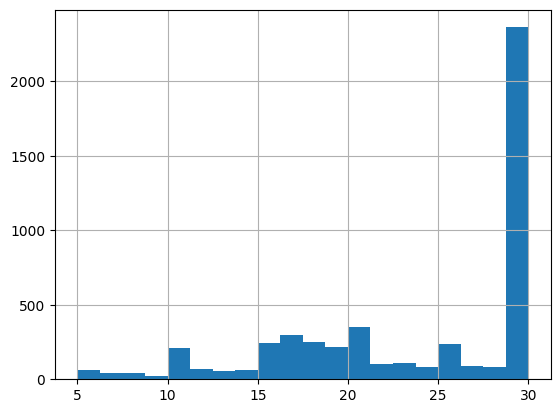

In [87]:
incorrect.word_count.hist(bins=20)

In [120]:
d = predictions_test_df.value_counts('word_count')
for key, value in incorrect.word_count.value_counts().items():
    print(f"WordCount: {key}, % of WordCount: {d[key]/30600*100:.2f}%, % of error in this WordCount: {value/d[key]*100:.2f}%")

WordCount: 30, % of WordCount: 49.22%, % of error in this WordCount: 15.01%
WordCount: 17, % of WordCount: 3.53%, % of error in this WordCount: 27.20%
WordCount: 18, % of WordCount: 3.42%, % of error in this WordCount: 23.66%
WordCount: 19, % of WordCount: 3.47%, % of error in this WordCount: 20.17%
WordCount: 20, % of WordCount: 3.48%, % of error in this WordCount: 18.59%
WordCount: 16, % of WordCount: 2.54%, % of error in this WordCount: 19.97%
WordCount: 21, % of WordCount: 2.97%, % of error in this WordCount: 16.72%
WordCount: 25, % of WordCount: 2.26%, % of error in this WordCount: 19.91%
WordCount: 11, % of WordCount: 2.05%, % of error in this WordCount: 19.01%
WordCount: 23, % of WordCount: 2.33%, % of error in this WordCount: 15.71%
WordCount: 29, % of WordCount: 1.74%, % of error in this WordCount: 19.14%
WordCount: 22, % of WordCount: 2.40%, % of error in this WordCount: 13.90%
WordCount: 26, % of WordCount: 2.07%, % of error in this WordCount: 15.48%
WordCount: 27, % of Word

In [135]:
from sklearn.metrics import classification_report

report = classification_report(predictions_test_df['true_labels'], predictions_test_df['predicted_labels'], target_names=names2.values())
print(report)

              precision    recall  f1-score   support

          OM       0.80      0.80      0.80      1700
          SD       0.79      0.73      0.76      1700
          SA       0.98      0.97      0.97      1700
          KW       0.86      0.93      0.89      1700
          QA       0.88      0.85      0.86      1700
          LB       0.80      0.80      0.80      1700
          JO       0.79      0.83      0.80      1700
          SY       0.94      0.92      0.93      1700
          IQ       0.90      0.86      0.88      1700
          MA       0.90      0.85      0.87      1700
          EG       0.73      0.80      0.76      1700
          PL       0.80      0.78      0.79      1700
          YE       0.74      0.77      0.76      1700
          BH       0.71      0.74      0.72      1700
          DZ       0.94      0.93      0.94      1700
          AE       0.86      0.87      0.86      1700
          TN       0.89      0.85      0.87      1700
          LY       0.79    

In [130]:
accuracies = []
for i in range(0,18):
    l_pred_true = predictions_test_df[(predictions_test_df['predicted_labels'] == i) & (predictions_test_df['true_labels'] == i)]
    accuracies.append(len(l_pred_true) / len(predictions_test_df[predictions_test_df['predicted_labels'] == i]))
for i,acc in enumerate(accuracies):
    print(f"Accuracy for {names2[i]}: {acc:.4f}")

Accuracy for OM: 0.7293
Accuracy for SD: 0.9432
Accuracy for SA: 0.7102
Accuracy for KW: 0.7856
Accuracy for QA: 0.7404
Accuracy for LB: 0.9427
Accuracy for JO: 0.8043
Accuracy for SY: 0.8551
Accuracy for IQ: 0.8761
Accuracy for MA: 0.8996
Accuracy for EG: 0.8581
Accuracy for PL: 0.7979
Accuracy for YE: 0.7921
Accuracy for BH: 0.7910
Accuracy for DZ: 0.9764
Accuracy for AE: 0.8013
Accuracy for TN: 0.8936
Accuracy for LY: 0.8958


<Axes: >

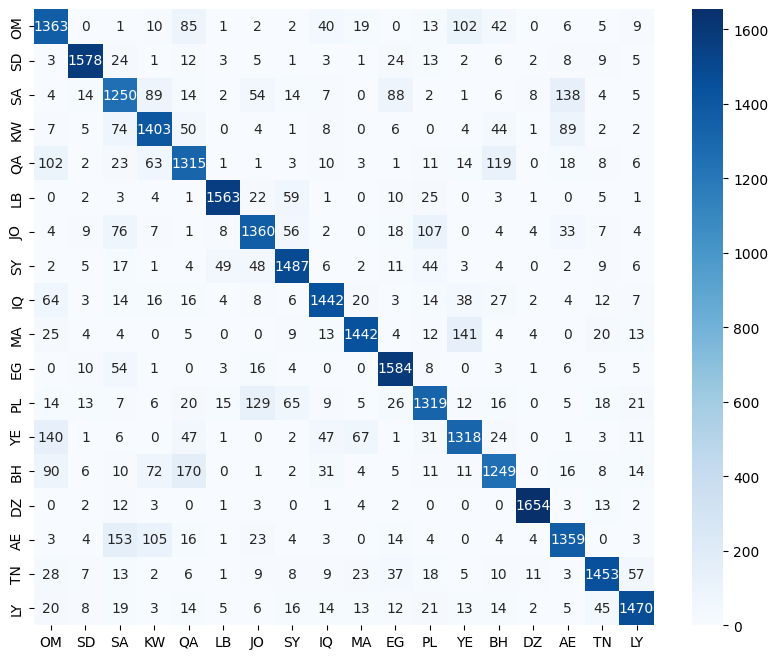

In [131]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(predictions_test_df['true_labels'], predictions_test_df['predicted_labels'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=names2.values(), yticklabels=names2.values())